In [1]:
suppressPackageStartupMessages(library(monocle))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(gridExtra))

In [13]:
prdata <- readRDS("source/prdata.sagar")
prdata2 <- prdata[rowSums(prdata) > 0,]   # get non-zero genes

## Initial non-zero filter

In [14]:
tab <- rbind(
    dim(prdata),
    dim(prdata2)
)
colnames(tab) <- c("Genes", "Cells")
rownames(tab) <- c("Raw", "Filt")
tab

Genes Cells
Raw  33901 430  
Filt 19977 430

In [436]:
head(prdata)

SAE725FACS1_1_1 SAE725FACS1_1_2 SAE725FACS1_1_3 SAE725FACS1_1_4
0610007P14Rik 0.000000        0.000000        1.000122        4.001954       
0610009B22Rik 0.000000        3.001099        4.001954        3.001099       
0610009E02Rik 0.000000        0.000000        0.000000        0.000000       
0610009L18Rik 0.000000        0.000000        0.000000        0.000000       
0610009O20Rik 0.000000        1.000122        0.000000        0.000000       
0610010F05Rik 1.000122        0.000000        0.000000        1.000122       
              SAE725FACS1_1_5 SAE725FACS1_1_6 SAE725FACS1_1_7 SAE725FACS1_1_8
0610007P14Rik 0.000000        1.000122        0               0              
0610009B22Rik 1.000122        4.001954        0               0              
0610009E02Rik 0.000000        0.000000        0               0              
0610009L18Rik 0.000000        0.000000        0               0              
0610009O20Rik 0.000000        1.000122        0               0              
0610010F05Rik 0.000000        0.000000        0               0              
              SAE725FACS1_1_9 SAE725FACS1_1_10 ⋯ SAE725FACS8_8_129
0610007P14Rik 0               1.000122         ⋯ 2.000488         
0610009B22Rik 0               1.000122         ⋯ 4.001954         
0610009E02Rik 0               0.000000         ⋯ 0.000000         
0610009L18Rik 0               0.000000         ⋯ 0.000000         
0610009O20Rik 0               0.000000         ⋯ 0.000000         
0610010F05Rik 0               0.000000         ⋯ 0.000000         
              SAE725FACS8_8_145 SAE725FACS8_8_148 SAE725FACS8_8_154
0610007P14Rik 2.000488          0.000000          0                
0610009B22Rik 1.000122          2.000488          0                
0610009E02Rik 0.000000          0.000000          0                
0610009L18Rik 0.000000          0.000000          0                
0610009O20Rik 0.000000          0.000000          0                
0610010F05Rik 0.000000          0.000000          0                
              SAE725FACS8_8_161 SAE725FACS8_8_164 SAE725FACS8_8_169
0610007P14Rik 3.001099          0                 0.000000         
0610009B22Rik 2.000488          0                 1.000122         
0610009E02Rik 0.000000          0                 0.000000         
0610009L18Rik 0.000000          0                 0.000000         
0610009O20Rik 2.000488          0                 0.000000         
0610010F05Rik 0.000000          0                 0.000000         
              SAE725FACS8_8_173 SAE725FACS8_8_177 SAE725FACS8_8_180
0610007P14Rik 1.000122          0                 1.000122         
0610009B22Rik 0.000000          0                 1.000122         
0610009E02Rik 0.000000          0                 0.000000         
0610009L18Rik 0.000000          0                 0.000000         
0610009O20Rik 0.000000          0                 1.000122         
0610010F05Rik 1.000122          0                 2.000488

## Create sample sheet and annotation data using bioMart (abandoned, not required)

In [ ]:
load_previous <- T

if (load_previous){
    k <- readRDS("k.biomart.monocle")
} else {
    suppressWarnings(require(biomaRt))
    # Annotate the data before adding SC experiment

    mart <- useMart(biomart = "ENSEMBL_MART_ENSEMBL", 
                    dataset = "mmusculus_gene_ensembl")

    k <- getBM(
        filters = "mgi_symbol",
        attributes = c(
                "mgi_symbol",
    #            "external_transcript_name",     # Transcript-specific name
    #            "gene_biotype",                 # Gene biotype
    #            "transcript_biotype",           # Trans type
                "description",                  # Gene description
    #            "band",                         # Karyotype band
    #            "refseq_mrna",
    #            "go_id",                        # Go Term accession (cellular domains)
    #            "go_linkage_type",              # Go Term evidence code
                "name_1006",                    # Go Term name
    #            "definition_1006",              # Go Term definition
                "namespace_1003"                # Go domain                  
        ),
        values = unique(rownames(prdata)),
        mart = mart
    )
    saveRDS(k, "k.biomart.monocle")   
}

In [ ]:
k_namespace1003 <- dcast(k[,c("mgi_symbol","namespace_1003")], mgi_symbol ~ namespace_1003)
#k_name1006 <- dcast(k[,c("mgi_symbol","name_1006")], mgi_symbol ~ name_1006)

head(k_namespace1003)
#head(k_name1006)


In [ ]:
# K is our featureData table, now we must make a phenoData -- although we 
#  know literally nothing except FACS plate and time of extraction
pdata <- colnames(prdata)
batch_number <- as.integer(sub(".*FACS([0-9]+)_.*", "\\1", pdata))
pdata <- data.frame(cbind(pdata, batch_number, "7.25"))
colnames(pdata) <- c("Cell", "Batch", "Time")
head(pdata)

In [ ]:
#prdata_new <- cbind(rownames(prdata), prdata)
#colnames(prdata_new)[1] <- "gene_short_name"
#head(prdata_new)

## Generate monocle data set

In [16]:
#pd <- new("AnnotatedDataFrame", data = pdata)
#fd <- new("AnnotatedDataFrame", data = k)
HSMM <- newCellDataSet(
    #as(as.matrix(prdata), "sparseMatrix"),
    as.matrix(prdata2),
    expressionFamily=negbinomial()  # negbinomial.size() is less accurate
)

Warning message in newCellDataSet(as.matrix(prdata2), expressionFamily = negbinomial()):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Warning message in newCellDataSet(as.matrix(prdata2), expressionFamily = negbinomial()):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Warning message in newCellDataSet(as.matrix(prdata2), expressionFamily = negbinomial()):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”

In [17]:
### Annotate feature data to have this required column
fData(HSMM) <- cbind(rownames(HSMM), fData(HSMM))
colnames(fData(HSMM))[1] <- "gene_short_name"
#head(fData(HSMM))

In [18]:
### Annotate cell data
batch_number <- c(as.integer(sub(".*FACS([0-9]+)_.*", "\\1", rownames(pData(HSMM)))))
pData(HSMM) <- cbind(pData(HSMM), batch_number)

In [19]:
HSMM <- estimateSizeFactors(HSMM)
HSMM <- estimateDispersions(HSMM)

Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step size truncated due to divergence”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”Warning message:
“step s

In [20]:
head(fData(HSMM))
head(pData(HSMM))
# Interestingly this is essentially what the initial sample sheet for the feature data looks like.

gene_short_name
0610007P14Rik 0610007P14Rik  
0610009B22Rik 0610009B22Rik  
0610009E02Rik 0610009E02Rik  
0610009L18Rik 0610009L18Rik  
0610009O20Rik 0610009O20Rik  
0610010F05Rik 0610010F05Rik

Size_Factor batch_number
SAE725FACS1_1_1 1.8534305   1           
SAE725FACS1_1_2 3.6475624   1           
SAE725FACS1_1_3 3.2656155   1           
SAE725FACS1_1_4 3.7335154   1           
SAE725FACS1_1_5 0.0961356   1           
SAE725FACS1_1_6 2.2981700   1

In [21]:
suppressPackageStartupMessages(library(data.table))
backup <- copy(HSMM)

## Examine distribution of counts and set limits

The idea here is to filter out any poor quality cells, and also to screen any doublets or triplets. We do this by using +/-2 standard deviations as a guide.

In [84]:
HSMM <- copy(backup)

### Filtering low quality cells

In [85]:
pData(HSMM)$Total_mRNAs <- Matrix::colSums(exprs(HSMM))

HSMM <- HSMM[,pData(HSMM)$Total_mRNAs < 1e6]

mean_upper <- 10^(mean(log10(pData(HSMM)$Total_mRNAs)) + 2*sd(log10(pData(HSMM)$Total_mRNAs)))
mean_lower <- 10^(mean(log10(pData(HSMM)$Total_mRNAs)) - 2*sd(log10(pData(HSMM)$Total_mRNAs)))

median_upper <- 10^(median(log10(pData(HSMM)$Total_mRNAs)) + 2*sd(log10(pData(HSMM)$Total_mRNAs)))
median_lower <- 10^(median(log10(pData(HSMM)$Total_mRNAs)) - 2*sd(log10(pData(HSMM)$Total_mRNAs)))

bounds <- rbind(as.integer(c(mean_lower, mean_upper)), as.integer(c(median_lower,median_upper)))
colnames(bounds) <- c("lower bound", "upper bound")
rownames(bounds) <- c("Mean", "Median")
bounds 

lower bound upper bound
Mean   443         226482     
Median 869         443630

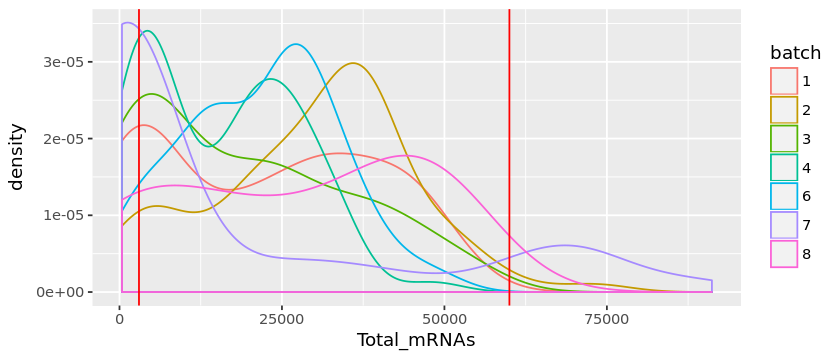

In [89]:
# Lower bound is less than the recommended 3000 transcript limit by Grün, so we will set it to that.
lower_bound <- 3000
upper_bound <- 60000   #, cells were FACS sorted -- doublets and triplets unlikely

options(repr.plot.height = 3)

batch <- factor(batch_number)

qplot(Total_mRNAs, data = pData(HSMM), color = batch, geom = "density"
) + geom_vline(xintercept = lower_bound, col= 'red'
              ) + geom_vline(xintercept = upper_bound, col = 'red')

# Yield same plot...
#qplot(Total_mRNAs, data = pData(HSMM[expressed_genes,]), color = batch, geom = "density"
#) + geom_vline(xintercept = lower_bound, col= 'grey'
#              )+ geom_vline(xintercept = upper_bound, col = 'grey')

Counts vary heavily between batches

In [90]:
# Filter on these limits
HSMM <- HSMM[,pData(HSMM)$Total_mRNAs > lower_bound & pData(HSMM)$Total_mRNAs < upper_bound]

### Filtering low-quality genes

In [91]:
# Min expr of 1 transcript (this was set 0.1 before...)
HSMM <- detectGenes(HSMM, min_expr = 0.1)   # Grün uses a minimum of 5
head(fData(HSMM))
expressed_genes <- row.names(subset(fData(HSMM), num_cells_expressed >= 2))  # this was set 10 before
message("Expressed genes: ", length(expressed_genes))


gene_short_name num_cells_expressed
0610007P14Rik 0610007P14Rik   213                
0610009B22Rik 0610009B22Rik   194                
0610009E02Rik 0610009E02Rik     4                
0610009L18Rik 0610009L18Rik     3                
0610009O20Rik 0610009O20Rik   104                
0610010F05Rik 0610010F05Rik    98

Expressed genes: 17014


### See how the data appears on a log-normalised scale

Warning message:
“Removed 5285904 rows containing non-finite values (stat_density).”

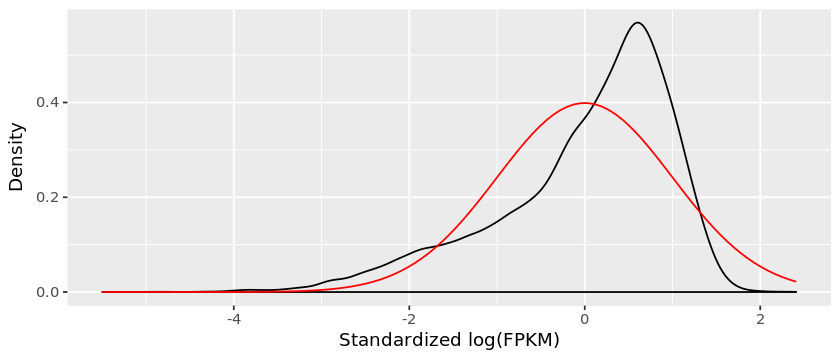

In [92]:
# Log-transform each value in the expression matrix.
L <- log(exprs(HSMM[expressed_genes,]))

# Standardize each gene, so that they are all on the same scale,
# Then melt the data with plyr so we can plot it easily
melted_dens_df <- melt(Matrix::t(scale(Matrix::t(L))))

# Plot the distribution of the standardized gene expression values.
qplot(
    value, geom = "density", data = melted_dens_df
) + stat_function(
    fun = dnorm, size = 0.5, color = 'red'
) + xlab("Standardized log(FPKM)") + ylab("Density")

This is a roughly log-normal distribution. Adjusting the filtering thresholds so that the number of expressed genes drops from 17,000 to 100 appears to have absolutely no effect on this plot. Neither does increasing the gene counting threshold of 0.1 to 1.

What *does* appear to affect this plot is reducing the upper-bound to 10 000, but such a low upper-limit is ridiculous.


In [93]:
backup2 <- copy(HSMM)

## Classifying cells

We can try tagging cells based on the expression from marker genes

In [121]:
# Define genes of interest, and their domains
gene_list <- c(
    "T", "Eomes", "Mesp1", 
    "Pou5f1", "Nanog", "Sox1", "Sox2",
    "Pou3f1", "Zfp462", "Slc7a3", "Lefty2"
)

is.embryonic_stemcell <- c("Pou5f1", "Nanog") # Oct-4 is a marker for Pou5f1
is.mesoderm <- c("Eomes", "T", "Mesp1")
is.antviscendo <- c("Cer1", "Lefty1")
is.neuroectoderm <- c("Sox1", "Sox2", "Pou3f1", "Zfp462", "Slc7a3")

Do these genes exist in our data still?

In [122]:
# Our genes of interest have survived the clustering
t(cbind(gene_list, gene_list %in% expressed_genes))

coll = ", "
cbind(
    rbind(
        paste(is.embryonic_stemcell, collapse=coll),
        paste(is.mesoderm, collapse=coll), 
        paste(is.antviscendo, collapse=coll), 
        paste(is.neuroectoderm, collapse=coll)
    )
    ,
    rbind(
        paste(is.embryonic_stemcell %in% rownames(HSMM), collapse=coll),
        paste(is.mesoderm %in% rownames(HSMM), collapse=coll),
        paste(is.antviscendo %in% rownames(HSMM), collapse=coll),
        paste(is.neuroectoderm %in% rownames(HSMM), collapse=coll)
    )
)
# All exist, woo.


[,1] [,2]  [,3]  [,4]   [,5]  [,6] [,7] [,8]   [,9]   [,10]  [,11] 
gene_list T    Eomes Mesp1 Pou5f1 Nanog Sox1 Sox2 Pou3f1 Zfp462 Slc7a3 Lefty2
          TRUE TRUE  TRUE  TRUE   TRUE  TRUE TRUE TRUE   TRUE   TRUE   TRUE

[,1]                               [,2]                        
[1,] Pou5f1, Nanog                      TRUE, TRUE                  
[2,] Eomes, T, Mesp1                    TRUE, TRUE, TRUE            
[3,] Cer1, Lefty1                       TRUE, TRUE                  
[4,] Sox1, Sox2, Pou3f1, Zfp462, Slc7a3 TRUE, TRUE, TRUE, TRUE, TRUE

### Build a cell heirarchy

According to this image from http://we.vub.ac.be/~cege/leyns/stem_cells.html

![title](images/ES_Diff.gif)

Let us now create a cell heirarchy based on some marker genes to help with our classification. 

There could be some issues here, however:

 * The list of genes we have might be of great interest to us, but they might be more subtle markers for delineating cell type than we think and it might fare better to consider some more prominent markers.

#### Strict types

The criteria here is that each cell must have at least 1 count of all genes listed in the gene group, with the strict condition that embryonic cells are do not have genes that have significant counts in other marker genes from other cell types.

This discrete classification essentially disregards any cell-heirarchy and treats ES, Mesodermic, Neuro-ectodermic, cells as seperate unrelated types.

(Note that setting a parent-cell type for each of the meso,neuro,asv types only gave a table of 96 ES and the rest unknown).


    Embryonic      Mesoderm Neuroectoderm       Unknown 
           96            48            13           155 

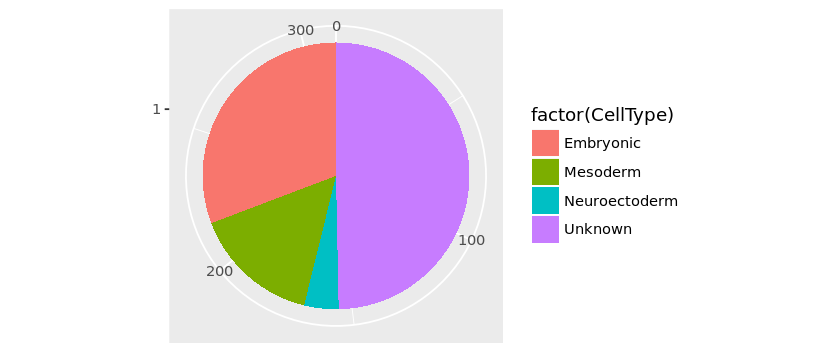

In [129]:
HSMM <- copy(backup2)

cth <- newCellTypeHierarchy()
cth <- addCellType(
    cth, "Embryonic", 
    # i.e STRICTLY embryonic -- Any cell that has at least 1 count in all embryonic genes, and less than 2 in other types
    classify_func = function(x) { 
        colSums(x[is.embryonic_stemcell,] >= 1) >= length(is.embryonic_stemcell) &
        colSums(x[is.mesoderm,] >= 1) < length(is.mesoderm) &
        colSums(x[is.neuroectoderm,] >= 1) < length(is.neuroectoderm) &
        colSums(x[is.antviscendo,] >= 1) < length(is.antviscendo)
    }
)
cth <- addCellType(
    cth, "Mesoderm",
    classify_func = function(x) { colSums(x[is.mesoderm,] >= 1) >= length(is.mesoderm)}
)
cth <- addCellType(
    cth, "Neuroectoderm",
    classify_func = function(x) { colSums(x[is.neuroectoderm,] >= 1) >= length(is.neuroectoderm)}
)
# This type is weak and may add noise to the anaylsis
cth <- addCellType(
    cth, "Anteriorvisceral",
    classify_func = function(x) { colSums(x[is.antviscendo,] >= 1) >= length(is.antviscendo)}
)

# We can tell this is a reasonable classification because we have no "ambiguous" cells.
HSMM <- classifyCells(HSMM, cth, 0.1)
table(pData(HSMM)$CellType)

pie <- ggplot(
    pData(HSMM), aes(x = factor(1), fill = factor(CellType))
) + geom_bar(width = 1)

pie + coord_polar(theta = "y") + theme(axis.title.x = element_blank(), axis.title.y = element_blank())

#### Heirarchal types

Here we relax the condition on embryonic cells to not express genes from other cell types. Interestingly even if we ask cell subtypes to not express their parent cell's genes, we get the same results as if we hadn't -- i.e. ES genes are clearly downregulated.


    Embryonic      Mesoderm Neuroectoderm       Unknown 
           96            23             9           184 

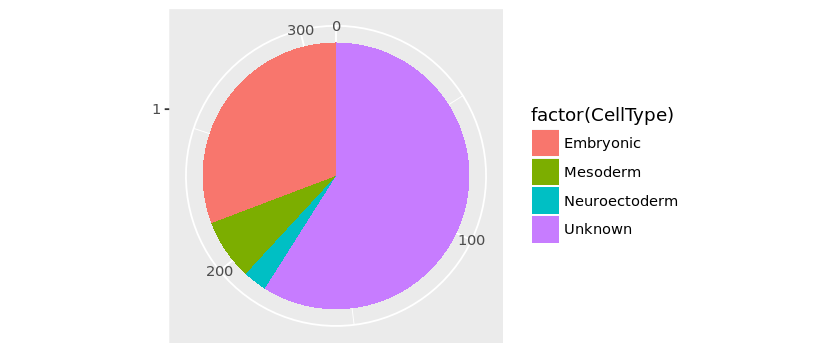

In [144]:
HSMM <- copy(backup2)

cth <- newCellTypeHierarchy()
cth <- addCellType(
    cth, "Embryonic", 
    classify_func = function(x) { 
        colSums(x[is.embryonic_stemcell,] >= 1) >= length(is.embryonic_stemcell)
    }
)
cth <- addCellType(
    cth, "Mesoderm",
    classify_func = function(x) { 
        colSums(x[is.mesoderm,] >= 1) >= length(is.mesoderm) 
#        colSums(x[is.embryonic_stemcell,] >= 1) <= length(is.embryonic_stemcell)
    },
    parent_cell_type_name = "Embryonic"
)
cth <- addCellType(
    cth, "Neuroectoderm",
    classify_func = function(x) { 
        colSums(x[is.neuroectoderm,] >= 1) >= length(is.neuroectoderm) 
#        colSums(x[is.embryonic_stemcell,] >= 1) <= length(is.embryonic_stemcell)
    },
    parent_cell_type_name = "Embryonic"
)
# This type is weak and may add noise to the anaylsis
cth <- addCellType(
    cth, "Anteriorvisceral",
    classify_func = function(x) {
        colSums(x[is.antviscendo,] >= 1) >= length(is.antviscendo) 
#        colSums(x[is.embryonic_stemcell,] >= 1) <= length(is.embryonic_stemcell)
    },
    parent_cell_type_name = "Embryonic"
)

# We can tell this is a reasonable classification because we have no "ambiguous" cells.
HSMM <- classifyCells(HSMM, cth, 0.1)
table(pData(HSMM)$CellType)

pie <- ggplot(
    pData(HSMM), aes(x = factor(1), fill = factor(CellType))
) + geom_bar(width = 1)

pie + coord_polar(theta = "y") + theme(axis.title.x = element_blank(), axis.title.y = element_blank())

Large Unknown cell types are common due to dropouts, but at least we don't have many ambiguous cell types.

In [145]:
backup3 <- copy(HSMM)

## Clustering

### Clustering without marker genes

Here we can try to discover some of these 'unknown' cell types by unsupervised cell clustering. First we must define a minimum cutoff of gene expression and only use genes with meaningful signal.

gene_id       mean_expression dispersion_fit dispersion_empirical
1 0610007P14Rik 0.552818634       3.742503      0.000000           
2 0610009B22Rik 0.530387618       3.900780      3.400387           
3 0610009E02Rik 0.004015389     515.248939      0.000000           
4 0610009L18Rik 0.002375956     870.775775      0.000000           
5 0610009O20Rik 0.182046200      11.364835     20.159160           
6 0610010F05Rik 0.159432030      12.976847      0.000000

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

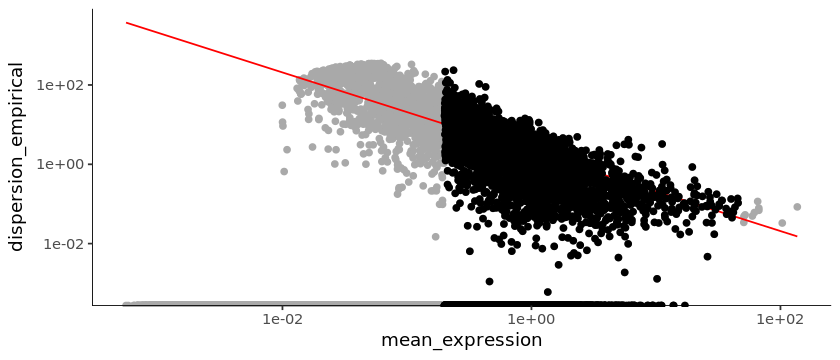

In [168]:
HSMM <- copy(backup3)
options(repr.plot.height=3)

disp_table <- dispersionTable(HSMM)
head(disp_table)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.2 & mean_expression <= 50)
HSMM <- setOrderingFilter(HSMM, unsup_clustering_genes$gene_id)  # sets flag for clusterCells
plot_ordering_genes(HSMM)

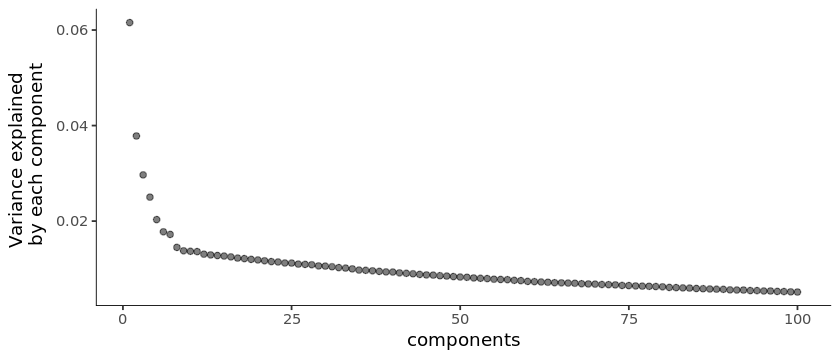

In [171]:
plot_pc_variance_explained(HSMM, return_all = F) # norm_method='log'
backup4 <- copy(HSMM)

It looks like the first 9 components contribute significantly to variance before the elbow plot flattens out.
We will iterate through each PC range to determine the best clustering.

In [245]:
sideBySide <- function(HSMM, dimm){
    grid.arrange(
        plot_cell_clusters(HSMM, 1, 2, color = "Cluster") + theme(
            legend.title=element_text(size=6), axis.title.x = element_blank(), axis.line.x = element_blank(),
            legend.text=element_text(size=6), axis.text = element_blank(), axis.line.y = element_blank(), 
            axis.ticks = element_blank()) + ylab(paste("Dim 1:", dimm, sep="")
        ),
        plot_cell_clusters(HSMM, 1, 2) + facet_wrap(~CellType) + theme(
            legend.title=element_text(size=6), axis.title = element_blank(), axis.line.x = element_blank(),
            legend.text=element_text(size=6), axis.text = element_blank(), axis.line.y = element_blank(), 
            axis.ticks = element_blank()
        ),
        layout_matrix = rbind(c(1,2))
    )
}

plotClusterRange <- function(dimm, form=NULL){
    
    HSMM <- copy(backup4)
    
    HSMM <- reduceDimension(
        HSMM, max_components = 3, num_dim = dimm,
        reduction_method = 'tSNE', 
        verbose = T,
        residualModelFormulaStr = form
    )
    
    HSMM <- clusterCells(HSMM)
    sideBySide(HSMM, dimm)
}

#### Dimension reduction with defaults

Dim1:4 gives a distinction between neuroecto and mesoderm, but mesoderm spans two clusters.  
Dim1:8 gives a much better distinction with mesoderm constrained to one cluster, but the variation should not have to be found so many components deep...

Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.596966 


Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 2.011832 


Remove noise by PCA ...
Reduce dimension by tSNE ...


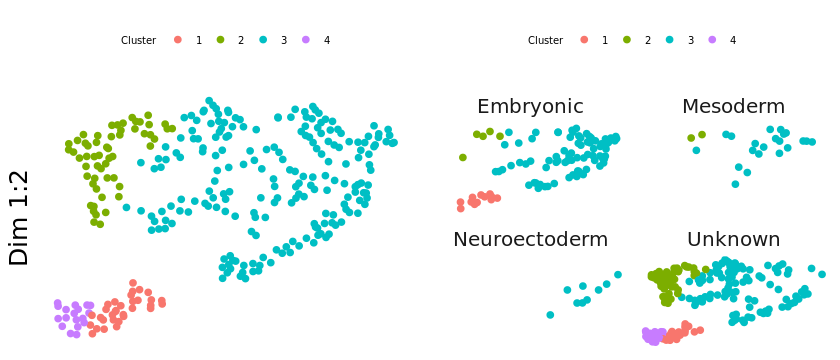

Distance cutoff calculated to 1.816754 


Remove noise by PCA ...
Reduce dimension by tSNE ...


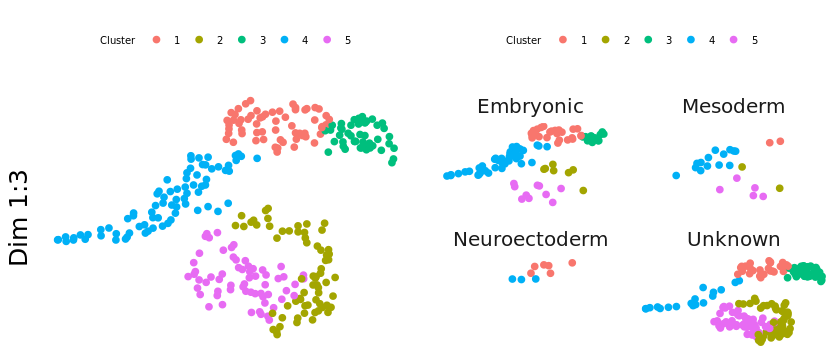

Distance cutoff calculated to 1.716195 


Remove noise by PCA ...
Reduce dimension by tSNE ...


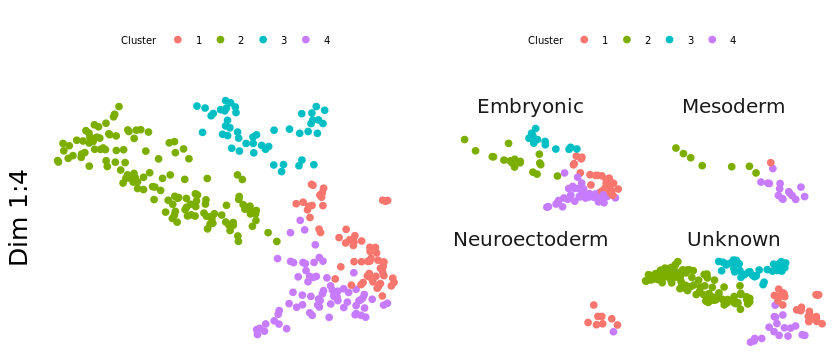

Distance cutoff calculated to 1.855529 


Remove noise by PCA ...
Reduce dimension by tSNE ...


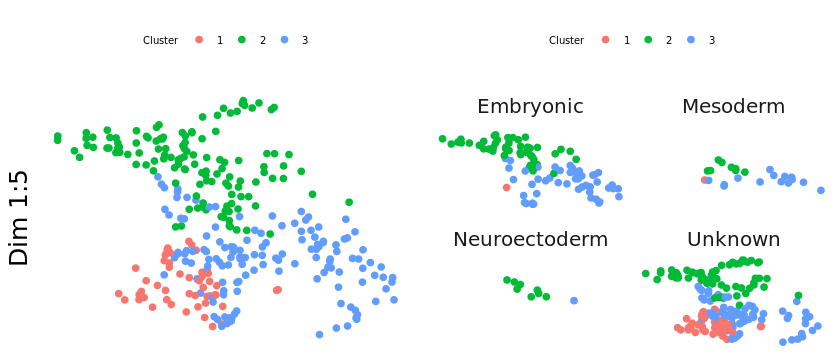

Distance cutoff calculated to 1.95274 


Remove noise by PCA ...
Reduce dimension by tSNE ...


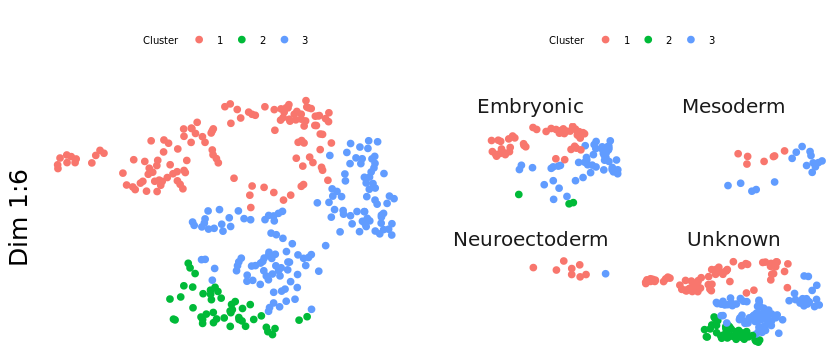

Distance cutoff calculated to 2.27238 


Remove noise by PCA ...
Reduce dimension by tSNE ...


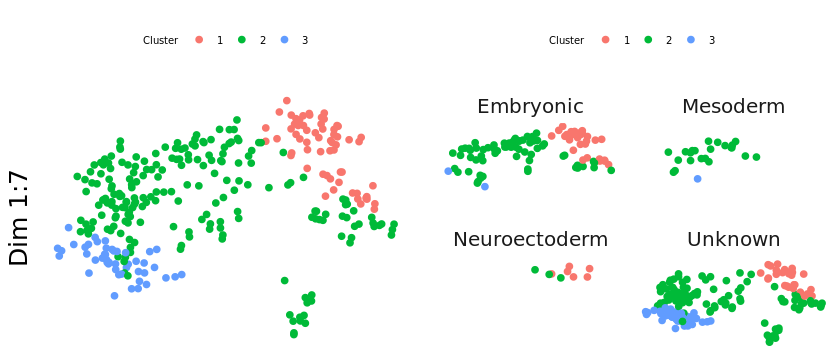

Distance cutoff calculated to 1.758964 


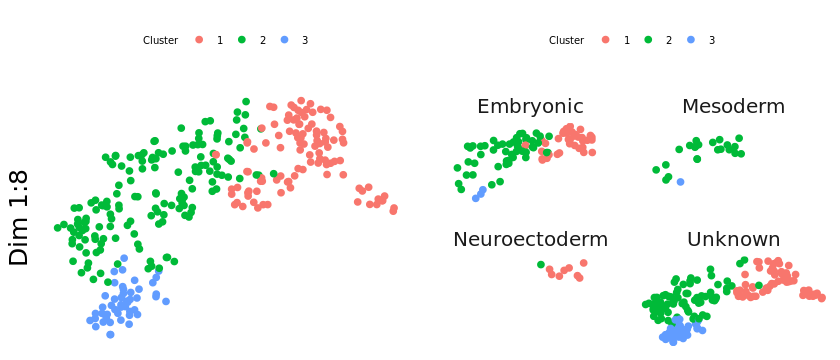

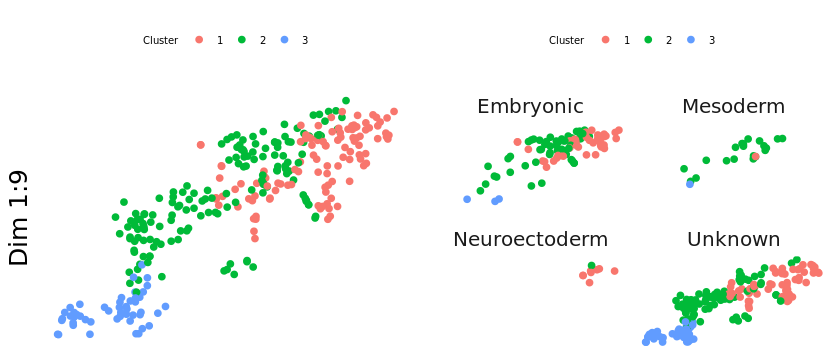

In [225]:
res <- lapply(2:9, plotClusterRange)

#### Dimension reduction with batch regressed out

Not very good distinction between the 3 groups at all in any of these. Clusters are too intermingled too.

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.243501 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 2.189242 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


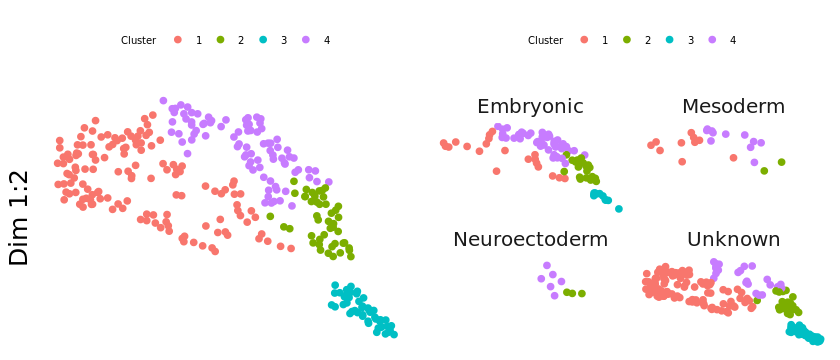

Distance cutoff calculated to 2.218531 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


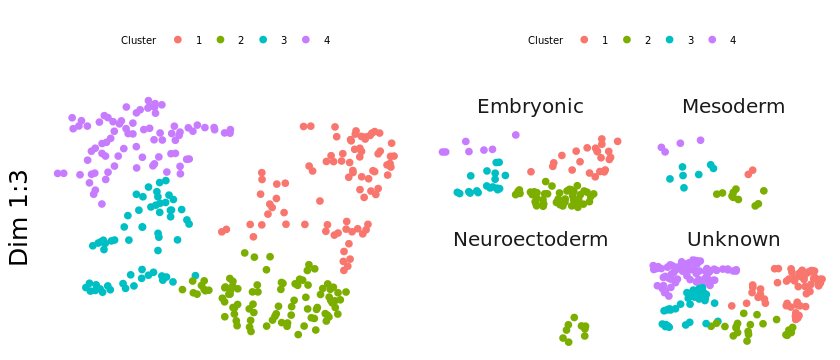

Distance cutoff calculated to 1.878909 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


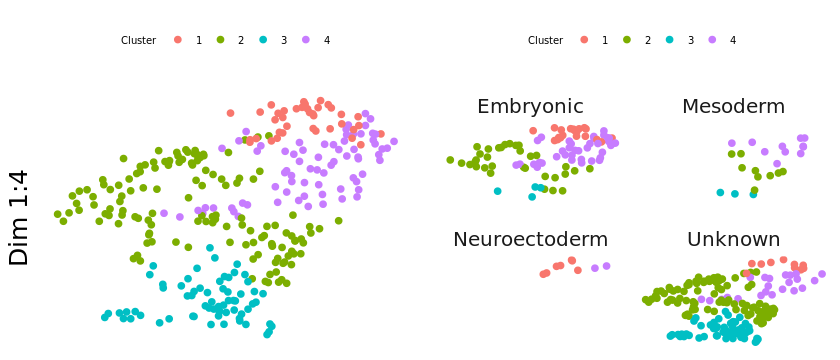

Distance cutoff calculated to 2.114424 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


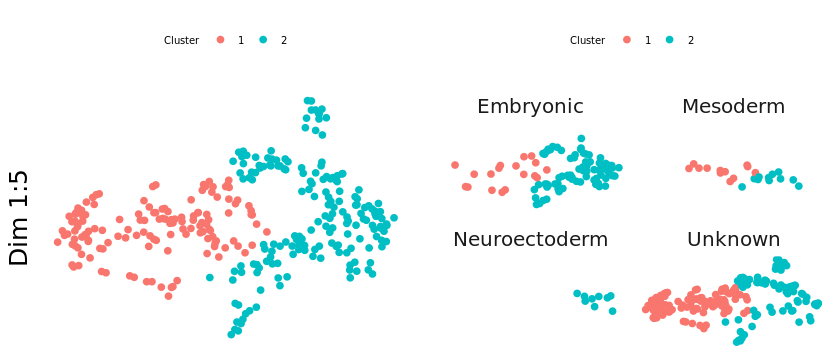

Distance cutoff calculated to 2.421819 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


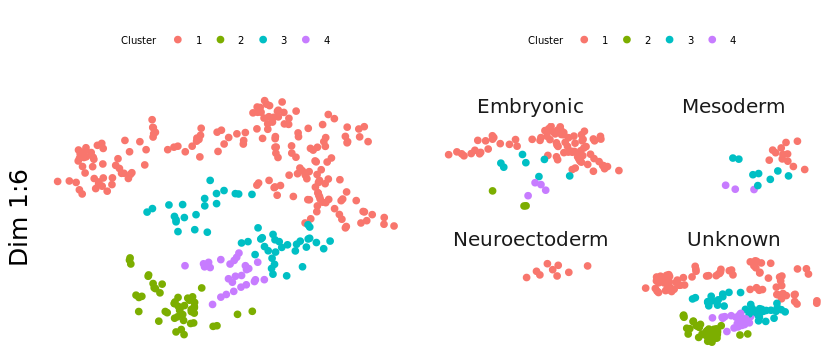

Distance cutoff calculated to 1.977437 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


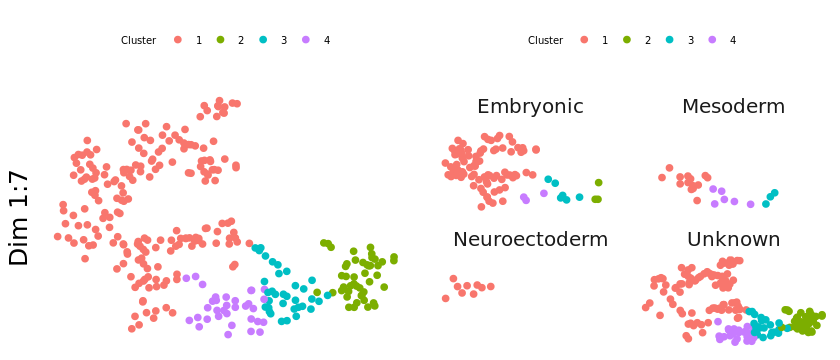

Distance cutoff calculated to 2.332222 


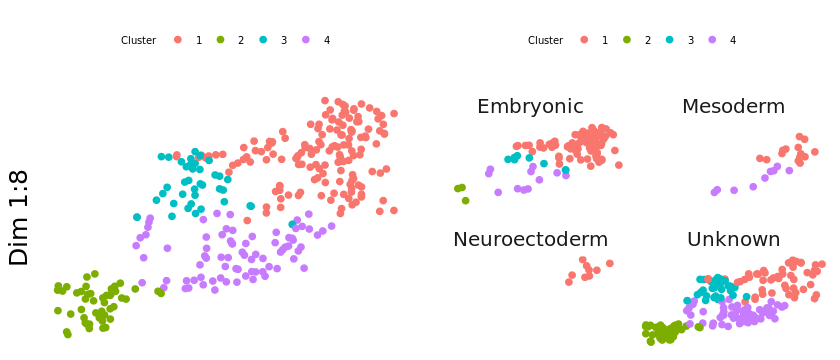

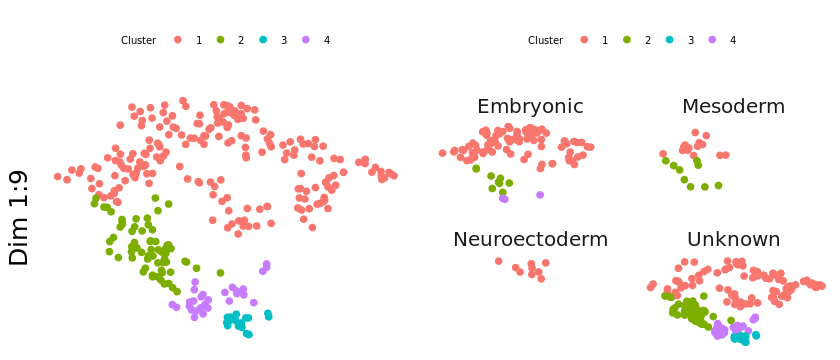

In [226]:
res <- lapply(2:9, function(x){
    plotClusterRange(x, "~batch_number")
})

#### Dimension reduction with batch and library size regressed out

Dim1:4 and Dim1:5 gives the best distinction between Neuroectoderm and Mesoderm

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.545888 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 2.610942 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


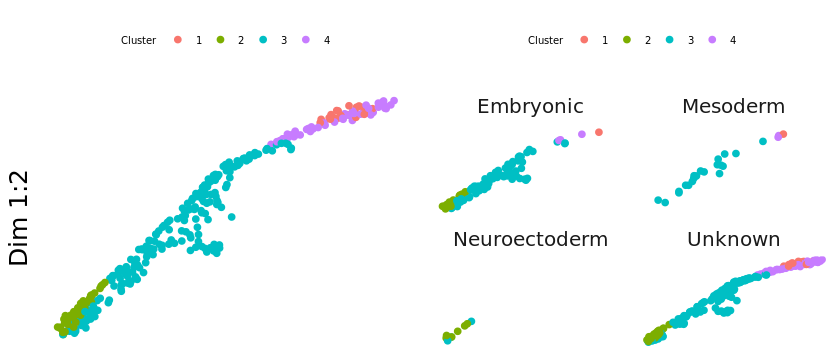

Distance cutoff calculated to 2.666371 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


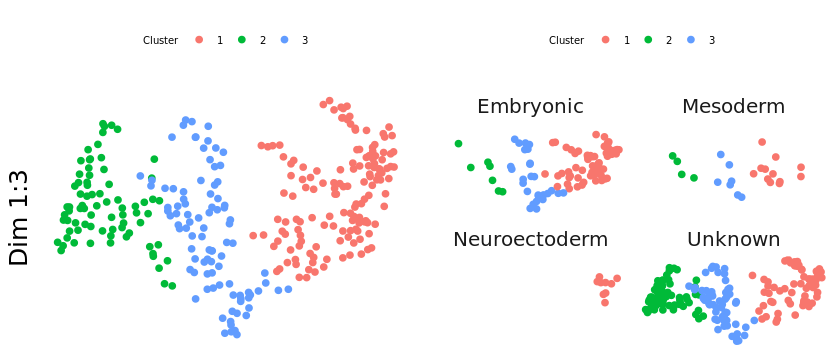

Distance cutoff calculated to 2.307619 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


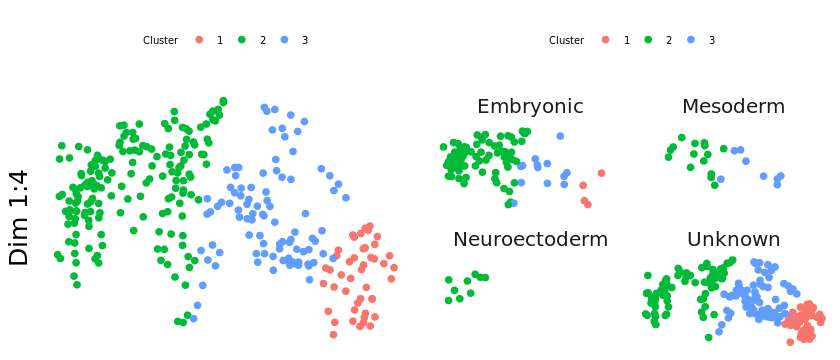

Distance cutoff calculated to 2.457504 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


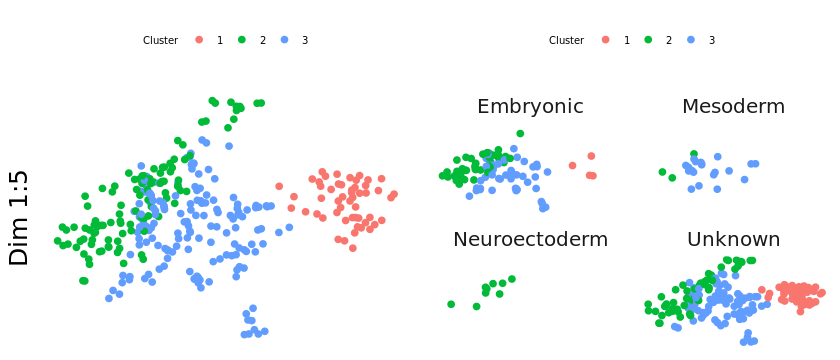

Distance cutoff calculated to 2.147122 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


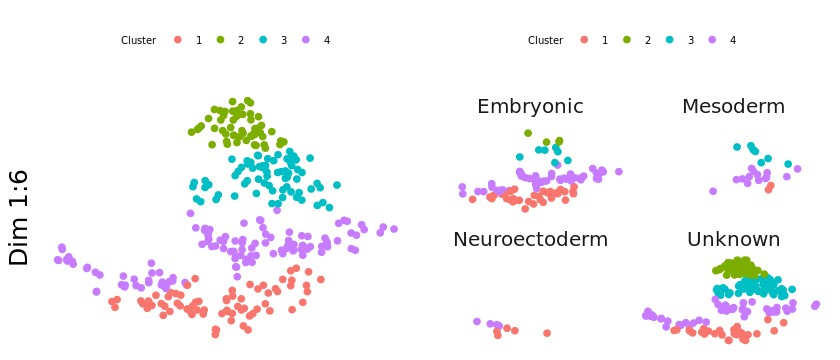

Distance cutoff calculated to 2.189164 


Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


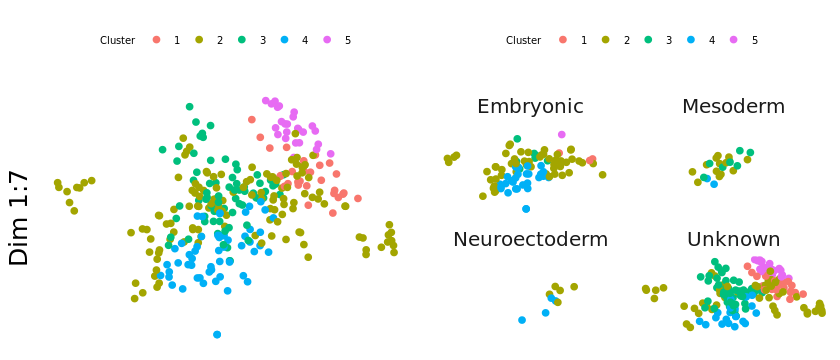

Distance cutoff calculated to 2.24463 


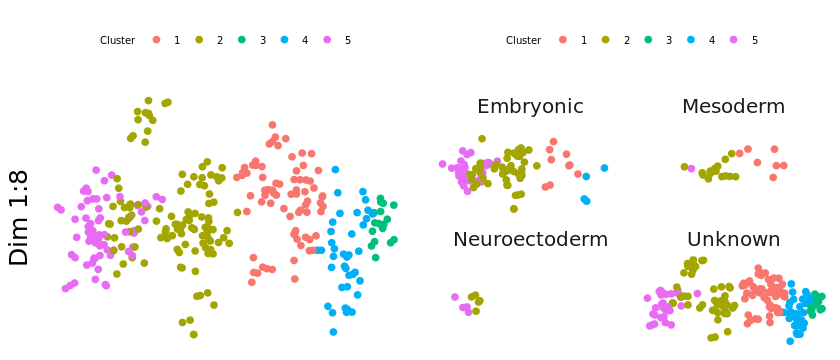

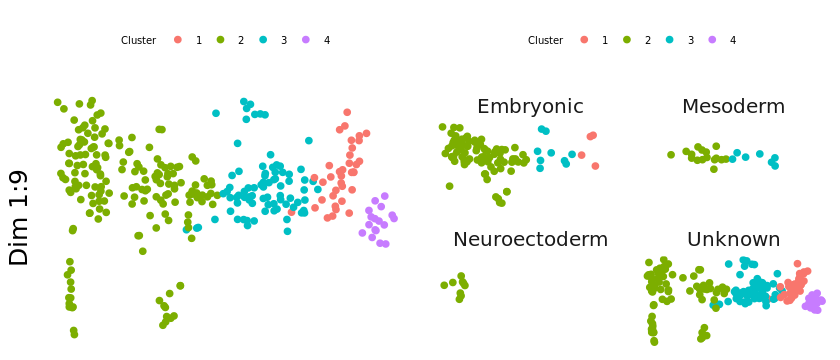

In [227]:
res <- lapply(2:9, function(x){
    plotClusterRange(x, "~batch_number + num_genes_expressed")
})

What's noticeable is that the embryonic cells don't seem to segragate away from the neuroectoderm cells in any particular way, and also seem prevalent in all clusters. I don't know whether this is expected or not.

### Clustering using marker genes

This is a semi-supervised approach to pick genes that co-vary with each other, effectively building a list of marker genes.

In [229]:
HSMM <- copy(backup3)

In [230]:
marker_diff <- markerDiffTable(
    HSMM,
    cth,
    residualModelFormulaStr = "~batch_number + num_genes_expressed",
    cores = 1
)

In [231]:
head(marker_diff)

status family      pval      qval      gene_short_name
0610007P14Rik OK     negbinomial 0.8798784 0.9999634 0610007P14Rik  
0610009B22Rik OK     negbinomial 0.4956968 0.9999634 0610009B22Rik  
0610009E02Rik OK     negbinomial 0.9865726 0.9999634 0610009E02Rik  
0610009L18Rik OK     negbinomial 0.9034075 0.9999634 0610009L18Rik  
0610009O20Rik OK     negbinomial 0.5485265 0.9999634 0610009O20Rik  
0610010F05Rik OK     negbinomial 0.6690651 0.9999634 0610010F05Rik  
              num_cells_expressed
0610007P14Rik 213                
0610009B22Rik 194                
0610009E02Rik   4                
0610009L18Rik   3                
0610009O20Rik 104                
0610010F05Rik  98

In [233]:
candidate_clustering_genes <- row.names(subset(marker_diff, qval < 0.01))
marker_spec <- calculateMarkerSpecificity(HSMM[candidate_clustering_genes,], cth)
head(selectTopMarkers(marker_spec, 3))

gene_id CellType  specificity
1 Gas1    Embryonic 0.5449556  
2 H19     Embryonic 0.6871390  
3 Tdgf1   Embryonic 0.6162981  
4 Gas1    Mesoderm  0.7769863  
5 Mesp1   Mesoderm  0.9076598  
6 Tdgf1   Mesoderm  0.7725609

Warning message:
“Transformation introduced infinite values in continuous y-axis”

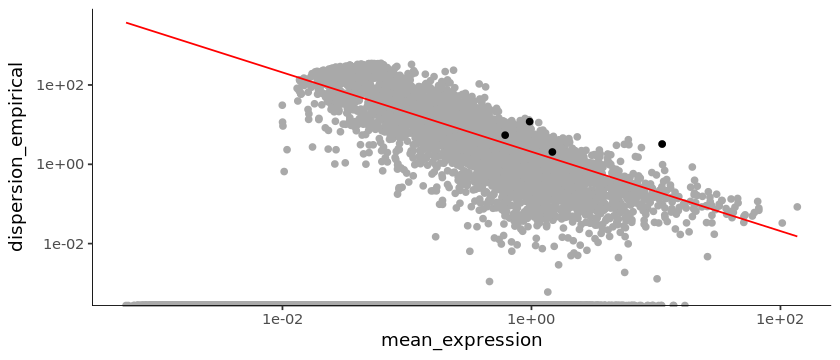

In [234]:
semisup_clustering_genes <- unique(selectTopMarkers(marker_spec, 500)$gene_id)
HSMM <- setOrderingFilter(HSMM, semisup_clustering_genes)
plot_ordering_genes(HSMM)

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”

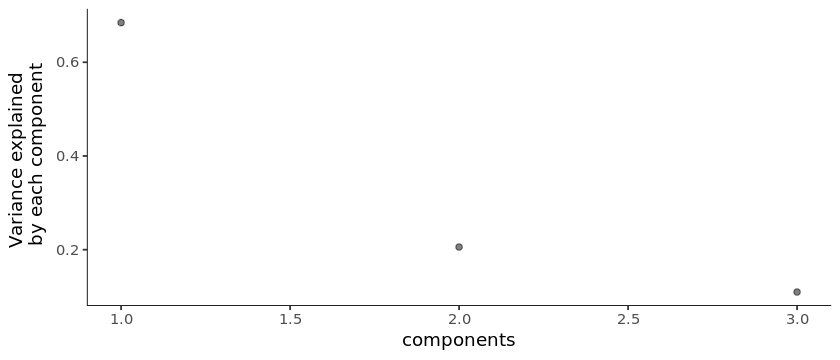

In [235]:
plot_pc_variance_explained(HSMM, return_all = F)

In [246]:
HSMM <- reduceDimension(HSMM, max_components = 2, num_dim = 3,
  norm_method = 'log',
  reduction_method = 'tSNE',
  residualModelFormulaStr = "~batch_number + num_genes_expressed",
  verbose = T)
HSMM <- clusterCells(HSMM, num_clusters = 2)
#plot_cell_clusters(HSMM, 1, 2, color = "CellType")
#sideBySide(2)

Removing batch effects
Remove noise by PCA ...
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”Reduce dimension by tSNE ...


Distance cutoff calculated to 1.419892 


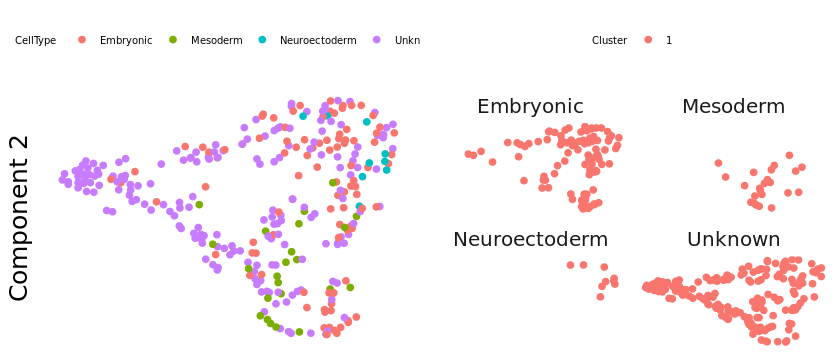

In [251]:
grid.arrange(
    plot_cell_clusters(HSMM, 1, 2, color = "CellType") + theme(
        legend.title=element_text(size=6), axis.title.x = element_blank(), axis.line.x = element_blank(),
        legend.text=element_text(size=6), axis.text = element_blank(), axis.line.y = element_blank(), 
        axis.ticks = element_blank() #) + ylab(paste("Dim 1:", dimm, sep="")
    ),
    plot_cell_clusters(HSMM, 1, 2) + facet_wrap(~CellType) + theme(
        legend.title=element_text(size=6), axis.title = element_blank(), axis.line.x = element_blank(),
        legend.text=element_text(size=6), axis.text = element_blank(), axis.line.y = element_blank(), 
        axis.ticks = element_blank()
    ),
    layout_matrix = rbind(c(1,2))
)

### Imputing clusters (abandoned)

We can try imputing now so that the frequency of cell types determines the cluster type

Distance cutoff calculated to 1.419892 


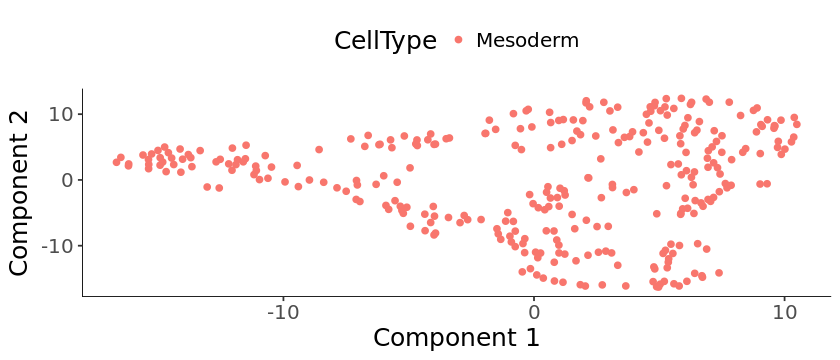

In [252]:
HSMM <- clusterCells(HSMM,
              num_clusters = 2,
              frequency_thresh = 0.1,
              cell_type_hierarchy = cth)
plot_cell_clusters(HSMM, 1, 2, color = "CellType")

Our data is too few and too sparse to impute properly on, abandoning this approach.

### Examining the most expressive genes in each cluster

We will proceed with clustering from the "Clustering without marker genes" section. Despite some mixed clustering, this method gave the best seperation between neuroectoderm and mesoderm (especially in Dim1:5).

Here we will iterate once again through the dimension range, but this time examining the expression of our genes of interest.

In [285]:
clusterUptoDimm <- function(dimm, residual = TRUE){
    HSMM <- copy(backup4)
    
    if (residual){
        HSMM <- reduceDimension(
            HSMM, max_components = 2, num_dim = dimm, 
            norm_method = 'log', reduction_method = 'tSNE',
            residualModelFormulaStr = "~batch_number + num_genes_expressed",
            verbose = T
        )
    } else {
        HSMM <- reduceDimension(
            HSMM, max_components = 2, num_dim = dimm, 
            norm_method = 'log', reduction_method = 'tSNE',
            verbose = T
        )    
    }
    HSMM <- clusterCells(HSMM)

    options(repr.plot.height=10)

    grid.arrange(
        plot_cell_clusters(HSMM, 1, 2, markers = is.embryonic_stemcell) + xlab("") + ylab("ES") + theme(legend.position="none"),
        plot_cell_clusters(HSMM, 1, 2, markers = is.mesoderm) + xlab("") + ylab("Mesoderm") + theme(legend.position="none"),
        #plot_cell_clusters(HSMM, 1, 2, markers = is.antviscendo) + xlab("") + ylab("Anterior Visceral Endoderm") + theme(legend.position="none"),
        plot_cell_clusters(HSMM, 1, 2, markers = is.neuroectoderm) + xlab("") + ylab("Neuro Ectoderm") + theme(legend.position="none"),
        
        plot_cell_clusters(HSMM, 1, 2) + theme(legend.title=element_text(size=4), axis.title = element_blank()),
        
        plot_cell_clusters(
            HSMM, 1, 2, color = "CellType"
        ) + scale_colour_manual(
            values = c("red", "blue", "green","gray89")
        ) + theme(legend.title=element_text(size=4), axis.title = element_blank()),
        
        plot_cell_clusters(
            HSMM, 1, 2, color = "CellType"
        ) + scale_colour_manual(
            values = c("red", "blue", "green", NA)
        ) + theme(legend.title=element_text(size=4), axis.title = element_blank()),

        layout_matrix = rbind(
            c(4,5,6),
            c(4,5,6),
            c(3,3,3),
            c(3,3,3),
            c(3,3,3),
            c(2,2,2),
            c(2,2,2),
            c(1,1,NA),
            c(1,1,NA)
        )
    )
}

#### Dim1:2

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.166502 


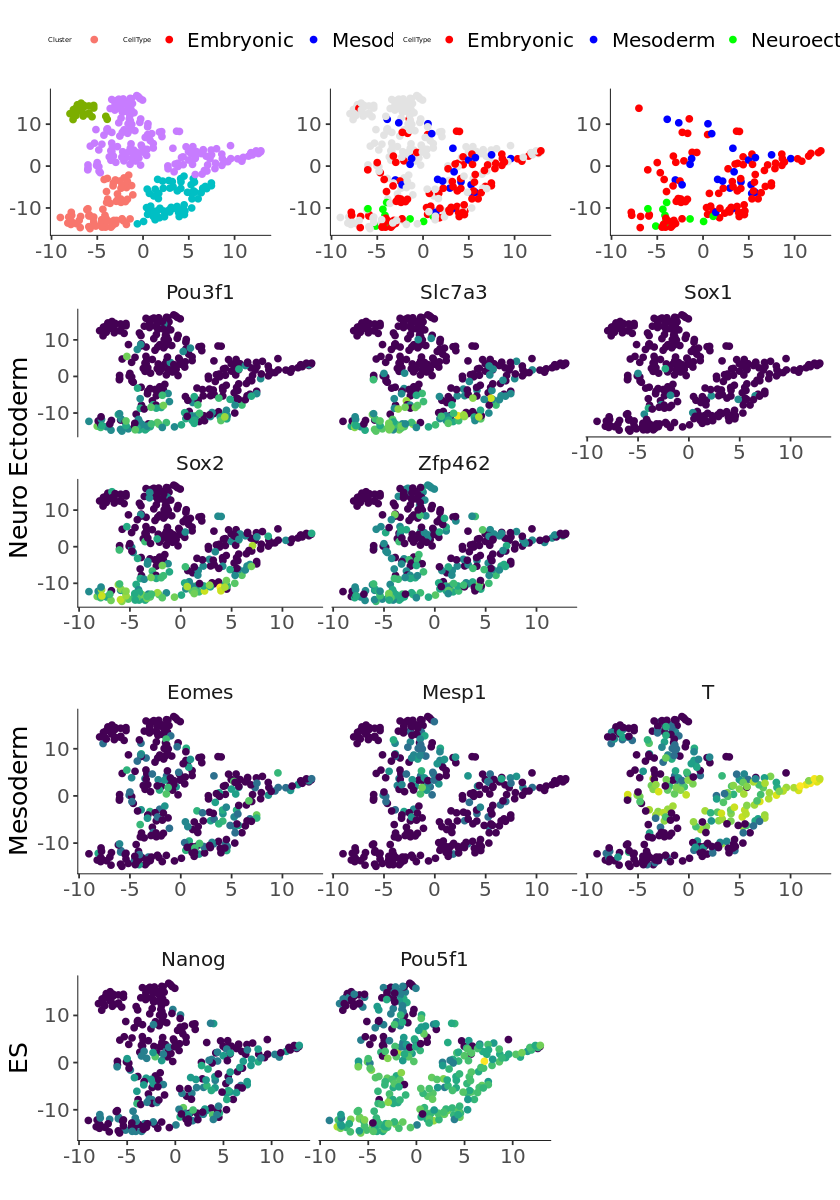

In [286]:
clusterUptoDimm(2)

#### Dim1:3

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.153031 


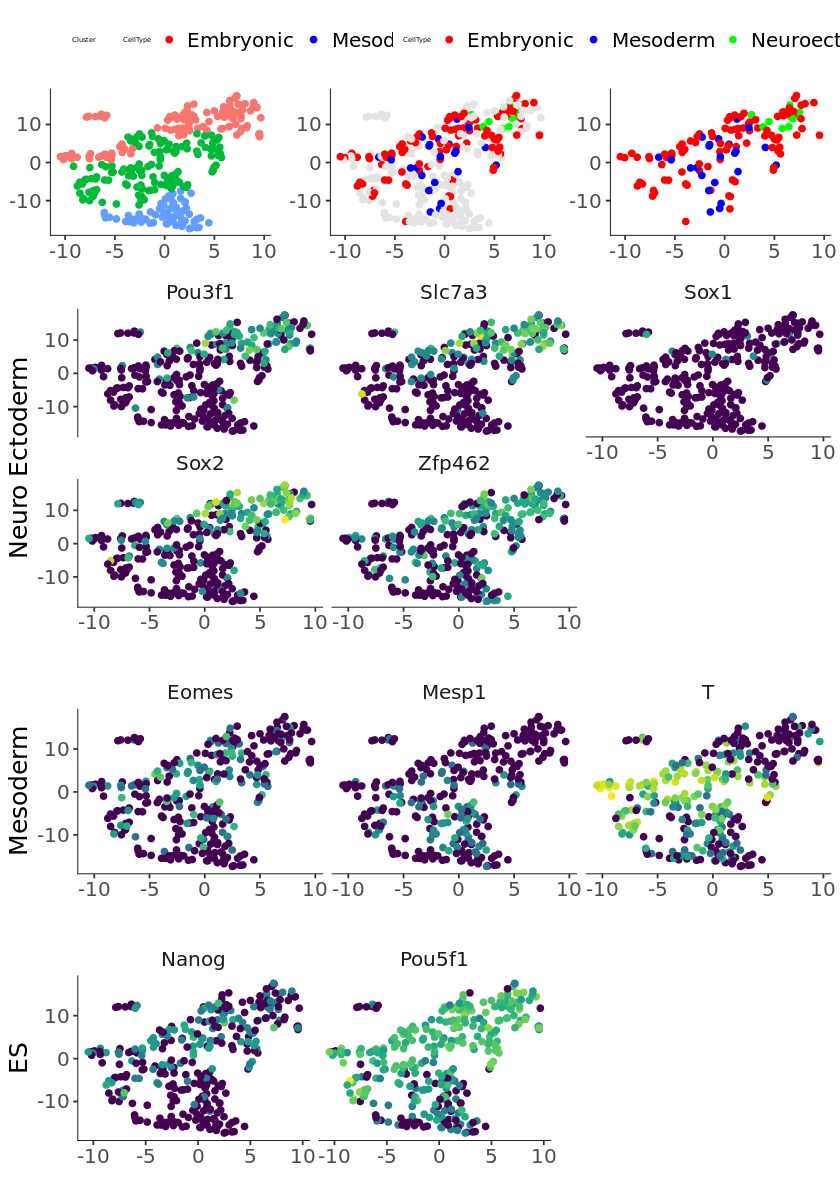

In [287]:
clusterUptoDimm(3)

#### Dim1:4

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.283592 


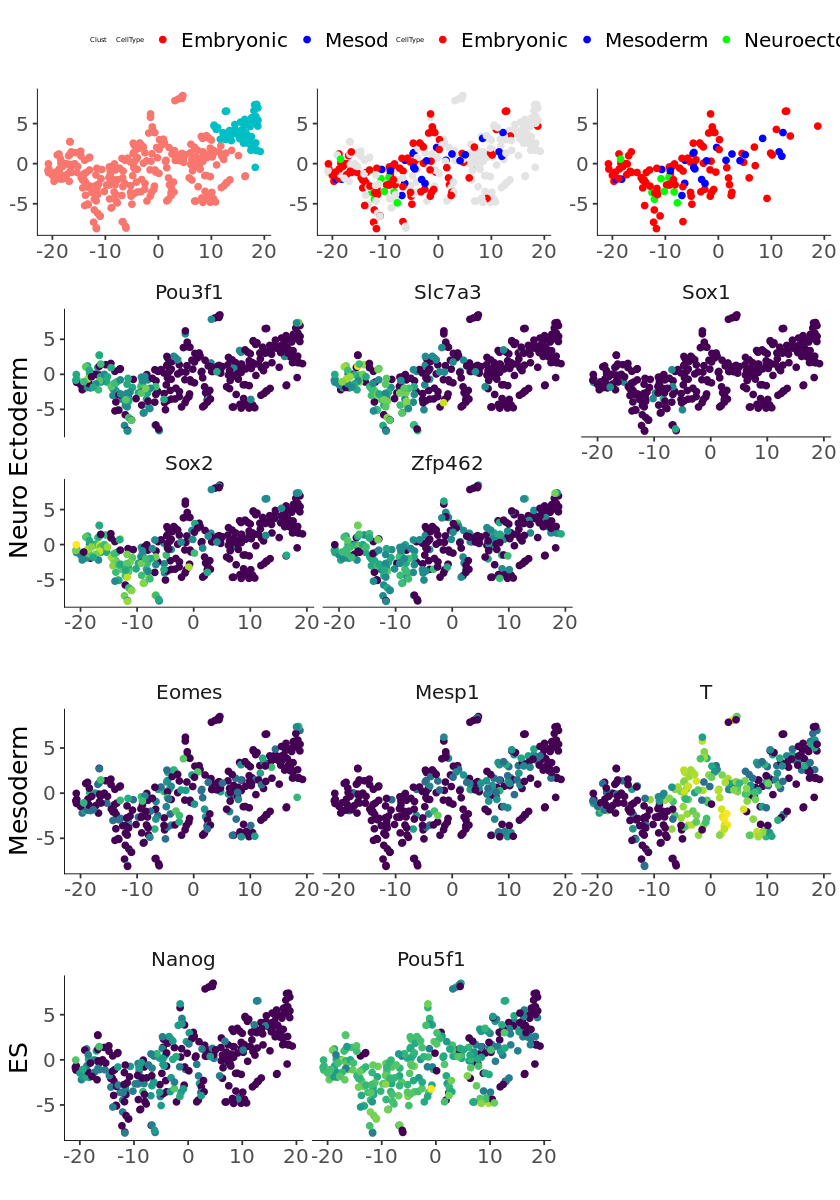

In [288]:
clusterUptoDimm(4)

#### Dim1:5

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.109703 


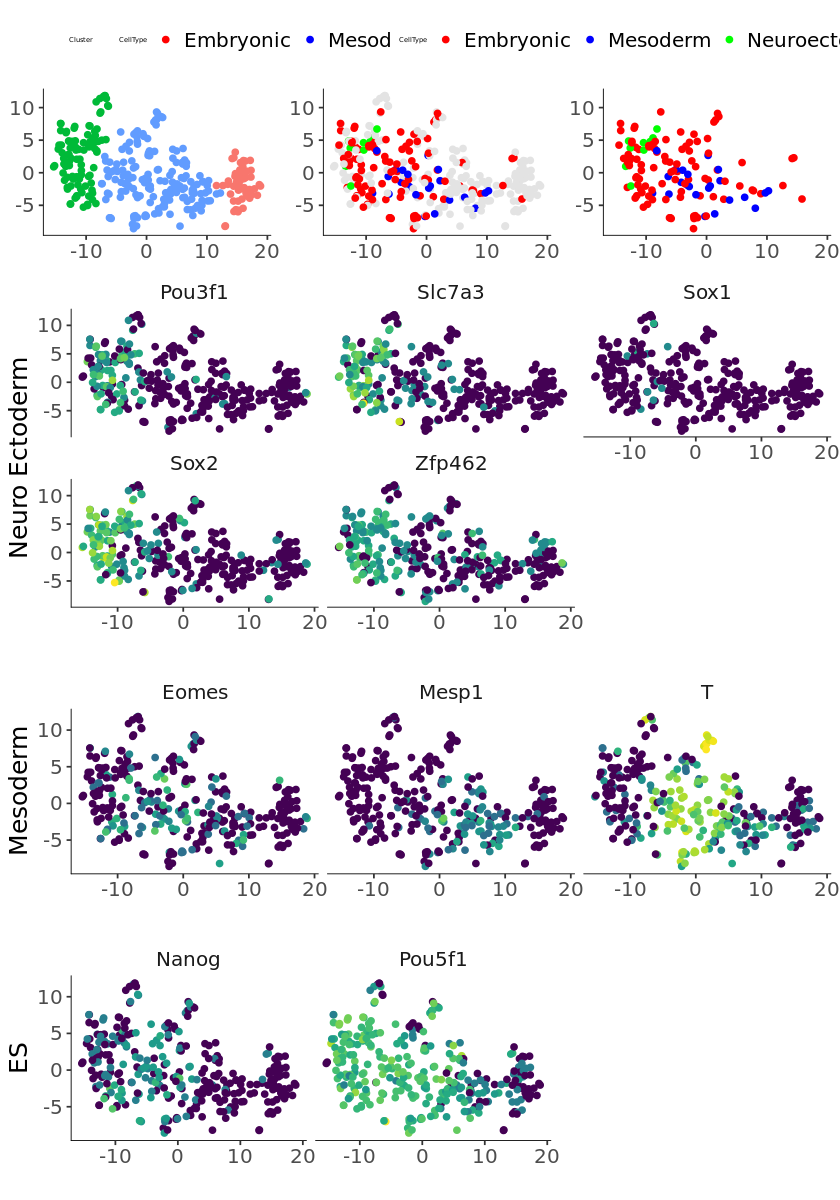

In [296]:
clusterUptoDimm(5)

#### Dim1:6

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.226361 


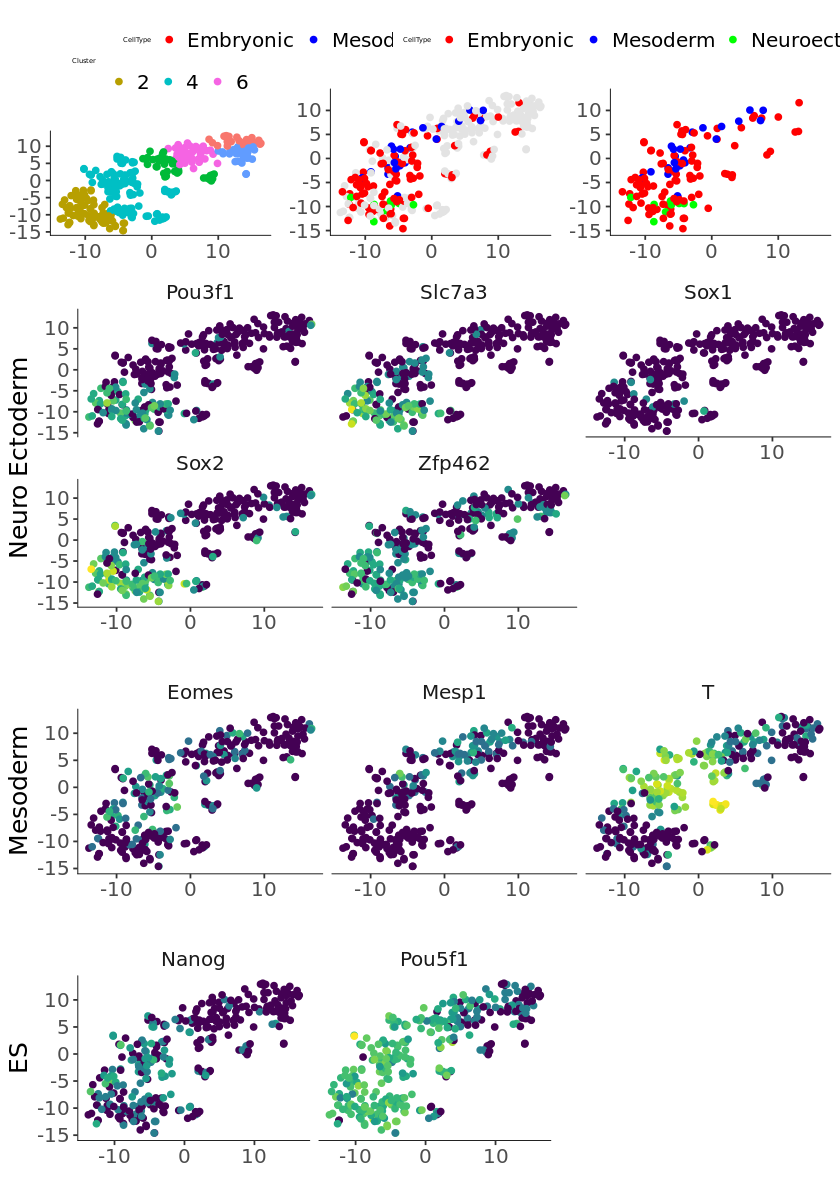

In [290]:
clusterUptoDimm(6)

#### Dim1:7

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.122783 


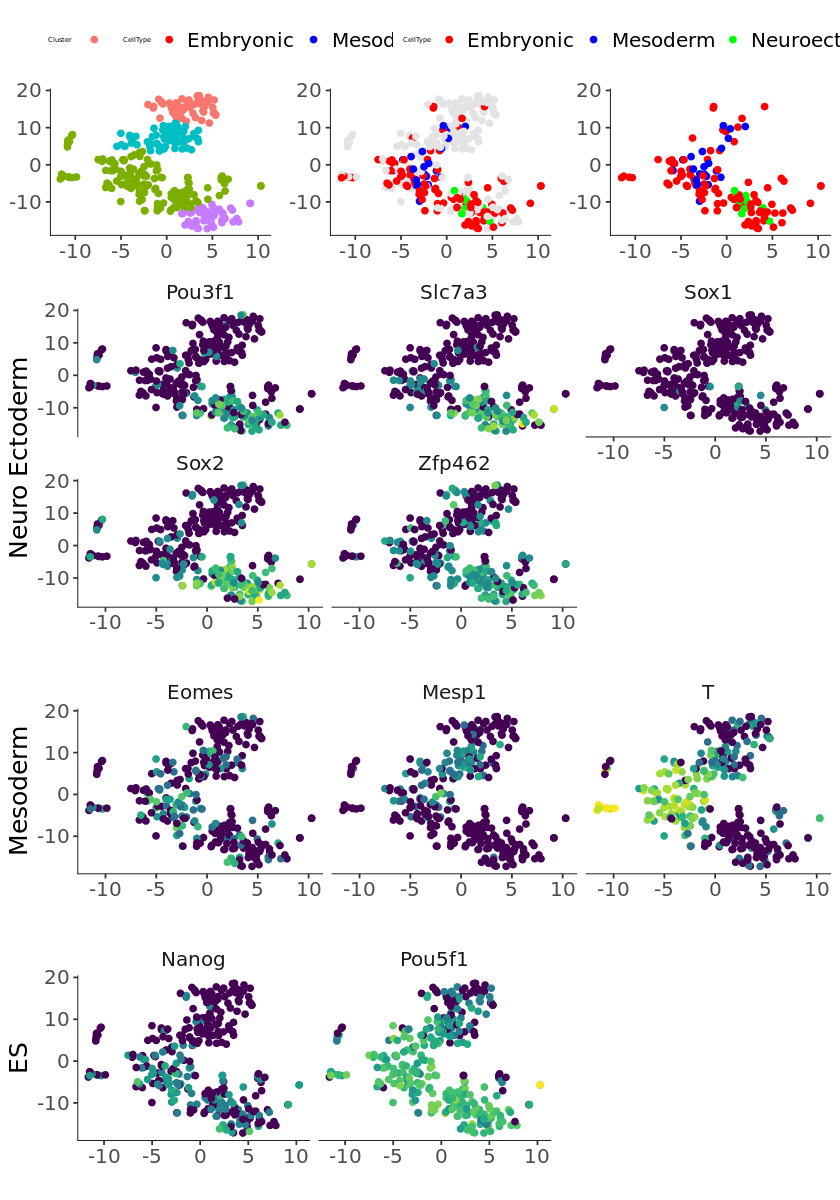

In [291]:
clusterUptoDimm(7)

#### Dim1:8

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.165469 


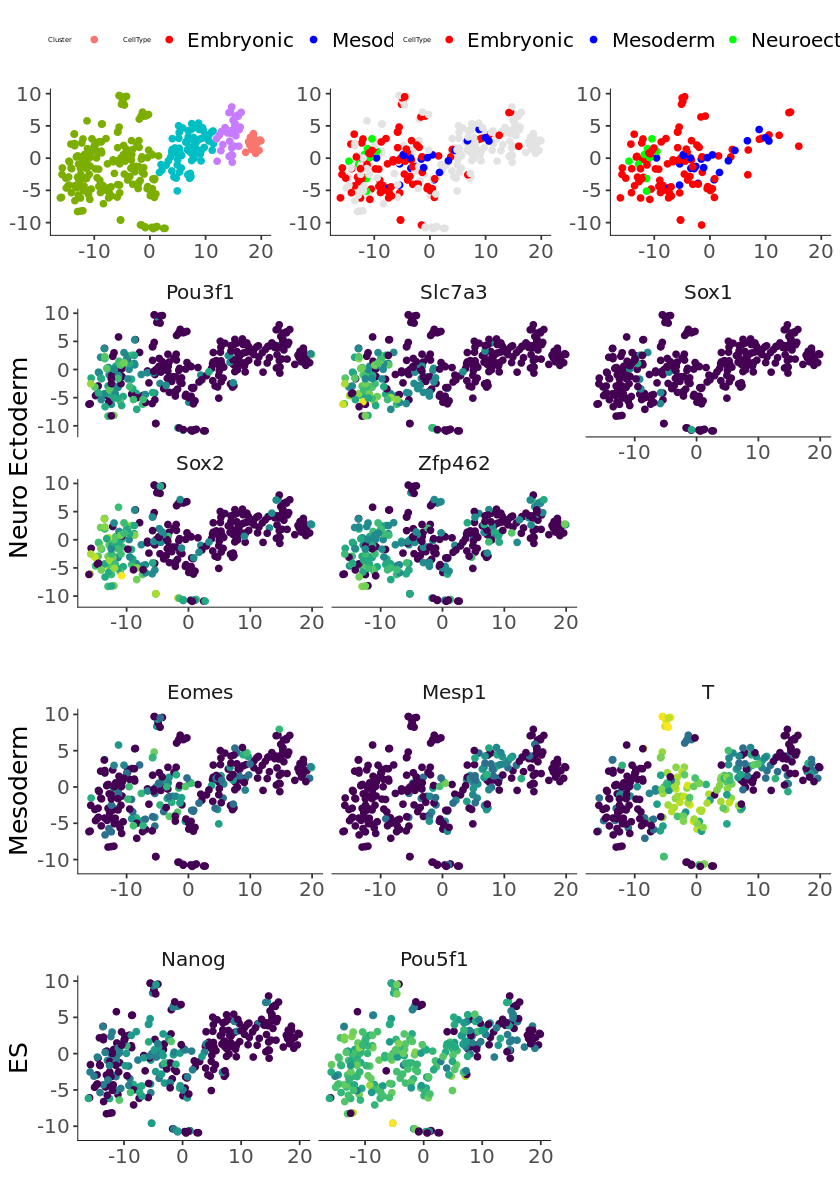

In [292]:
clusterUptoDimm(8)

#### Dim1:9

Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 1.118441 


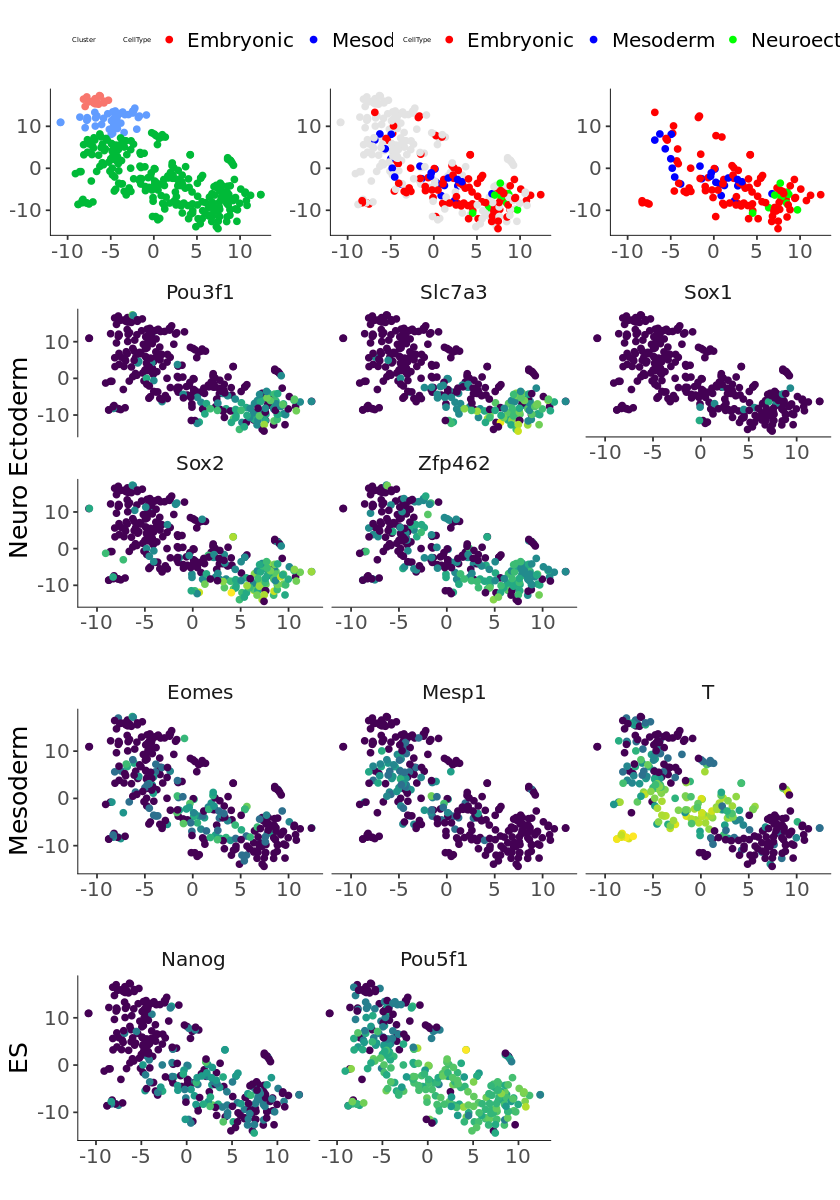

In [293]:
clusterUptoDimm(9)

#### Summary....

There definitely seems to be strong covariance with neuro-ectoderm genes, and also to some degree with the mesoderm genes.

Dim1:5 seems to give some great clustering.

Let's do some differential gene analysis which should hopefully shed a little more light on this.

## Cell Trajectories

In [314]:
# Find/set genes that define cell progress
HSMM <- copy(backup3)

disp_table <- dispersionTable(HSMM)
ordering_genes <- subset(disp_table, mean_expression >= 0.1)
HSMM <- setOrderingFilter(HSMM, ordering_genes)
HSMM <- reduceDimension(HSMM)
HSMM <- orderCells(HSMM)

In [316]:
#suppressPackageStartupMessages(library(monocle))
#suppressPackageStartupMessages(library(reshape))
#suppressPackageStartupMessages(library(gridExtra))
diff_test_res <- differentialGeneTest(HSMM)

In [318]:
head(diff_test_res)

status family      pval      qval      gene_short_name
0610007P14Rik OK     negbinomial 0.5175369 0.7227239 0610007P14Rik  
0610009B22Rik OK     negbinomial 0.0935816 0.3204894 0610009B22Rik  
0610009E02Rik OK     negbinomial 0.9668786 0.9821205 0610009E02Rik  
0610009L18Rik OK     negbinomial 0.5064439 0.7199897 0610009L18Rik  
0610009O20Rik OK     negbinomial 0.5509400 0.7383943 0610009O20Rik  
0610010F05Rik OK     negbinomial 0.3601659 0.6472152 0610010F05Rik  
              num_cells_expressed use_for_ordering
0610007P14Rik 213                 FALSE           
0610009B22Rik 194                 FALSE           
0610009E02Rik   4                 FALSE           
0610009L18Rik   3                 FALSE           
0610009O20Rik 104                 FALSE           
0610010F05Rik  98                 FALSE

In [322]:
sig_genes <- subset(diff_test_res, qval < 0.1)

#head(sig_genes) #[qval < 1e-20])
t(subset(sig_genes,qval < 1e-20)[,c("pval","num_cells_expressed")])

Cnn2         Cox6c        Cox7b        Cox7c       
pval                2.108609e-24 2.501064e-30 5.123081e-28 1.698075e-25
num_cells_expressed 2.190000e+02 3.080000e+02 3.100000e+02 3.120000e+02
                    Eef1b2       Gm9493       H19           Hspa5       
pval                1.010859e-26 1.678456e-36 3.107914e-177 2.227275e-29
num_cells_expressed 3.120000e+02 3.120000e+02  2.730000e+02 3.110000e+02
                    Hspe1        Ncl          ⋯ Rpl36al      Rpl4        
pval                2.786994e-36 1.277734e-24 ⋯ 1.813353e-26 2.539724e-29
num_cells_expressed 3.120000e+02 3.120000e+02 ⋯ 3.110000e+02 3.120000e+02
                    Rpl5        Rps13        Rps24       Rps25       
pval                1.82166e-31 3.665337e-40 2.52839e-45 3.197904e-43
num_cells_expressed 3.12000e+02 3.120000e+02 3.12000e+02 3.120000e+02
                    Rps27l       Rps3a1      Tma7         Tpt1        
pval                4.438716e-26 1.89715e-30 1.176367e-24 3.805671e-60
num_cells_expressed 3.090000e+02 3.12000e+02 3.110000e+02 3.120000e+02

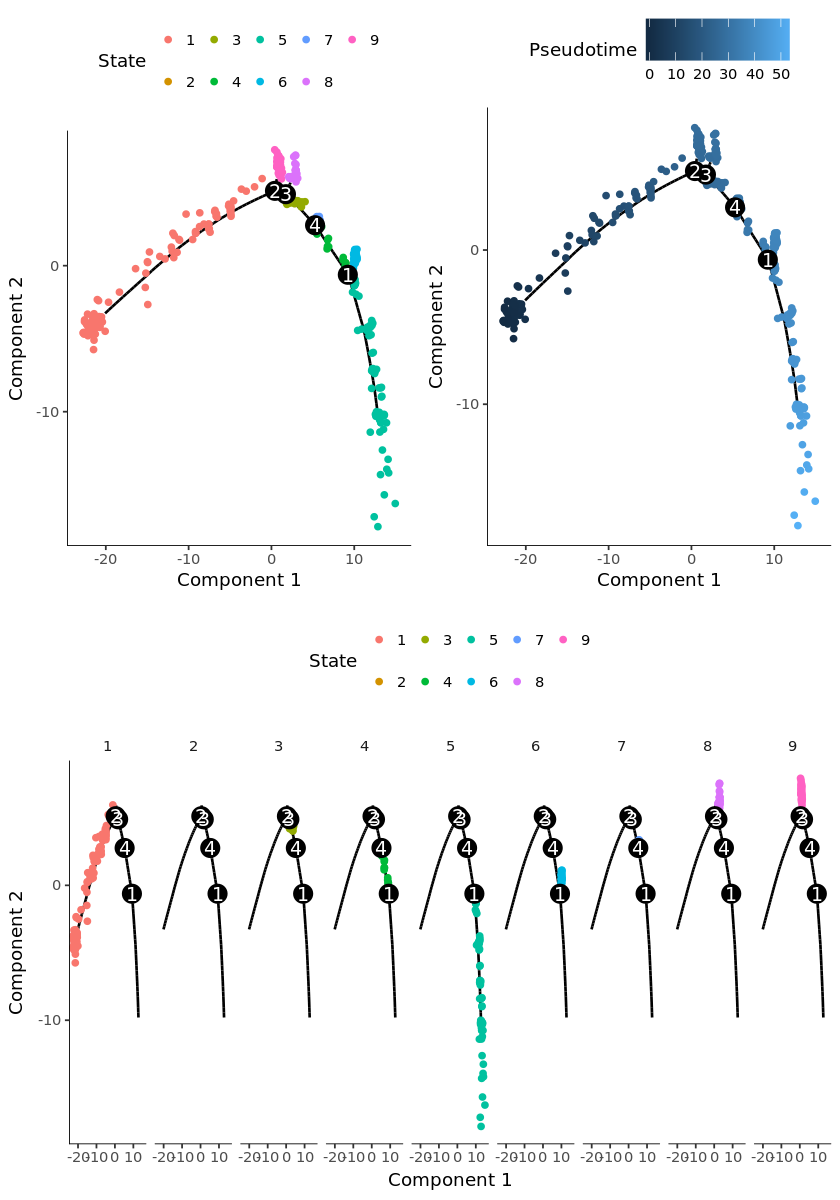

In [323]:
suppressPackageStartupMessages(library(gridExtra))
p1 <- plot_cell_trajectory(HSMM)
p2 <- plot_cell_trajectory(HSMM, color_by = "Pseudotime")
p3 <- plot_cell_trajectory(HSMM) + facet_wrap(~State, nrow = 1)

grid.arrange(p1, p2, p3, layout_matrix = rbind(c(1,2),c(3,3)))


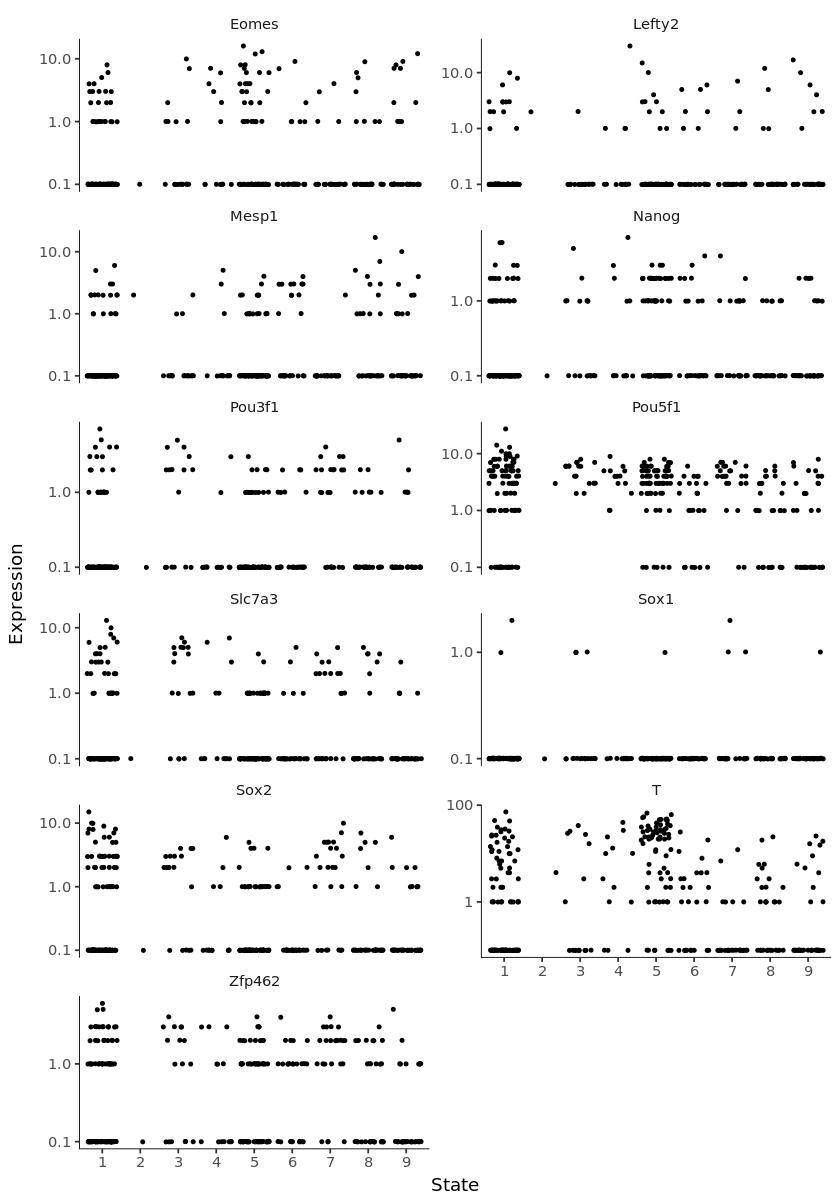

In [324]:
#fData(HSMM) <- cbind(rownames(HSMM), fData(HSMM))
#colnames(fData(HSMM))[1] <- "gene_short_name"
#head(fData(HSMM))

subgenes <- HSMM[row.names(subset(fData(HSMM),
              gene_short_name %in% gene_list)),]
plot_genes_jitter(subgenes, ncol= 2)


In [325]:
sig_genes_highrel <- row.names(subset(sig_genes,qval < 1e-20))
sig_genes_with_extras <- sort(unique(c(sig_genes_highrel, gene_list)))

### Differential Gene analysis

In [427]:
# Believe it or not, pheatmap does not return a ggplot object, but a grid object that cannot only be controlled by
# calling a new page between each.

suppressPackageStartupMessages(library(grid))

plotPseudoGLNumClust <- function(num_clust){
    options(repr.plot.pointsize=7)
    options(repr.plot.height=4)

    plot_pseudotime_heatmap(HSMM[sig_genes_with_extras,], show_rownames = T, num_clusters = num_clust)
    grid.newpage(recording = T)

    options(repr.plot.pointsize=7)
    options(repr.plot.height=2)

    plot_pseudotime_heatmap(HSMM[gene_list,], show_rownames = T, num_clusters = num_clust)
    grid.newpage(recording = T)
    plot_genes_branched_heatmap(HSMM[gene_list,], use_gene_short_name = T,show_rownames = T, num_clusters = num_clust)
}

#### Clusters = 2

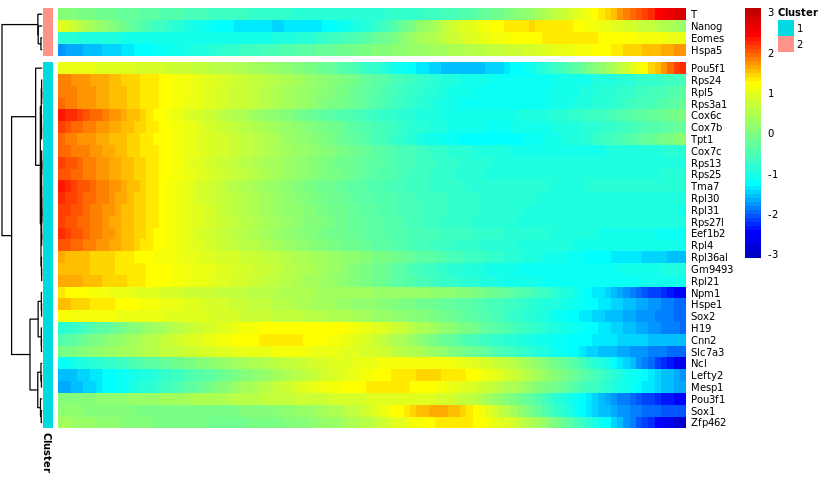

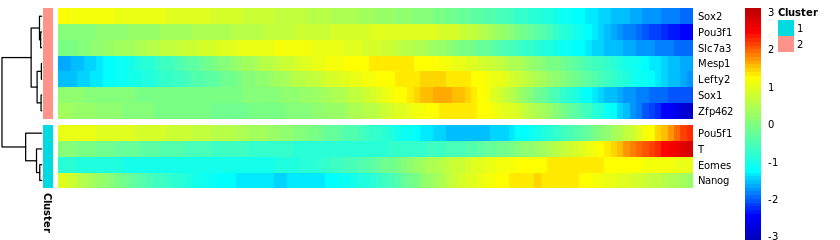

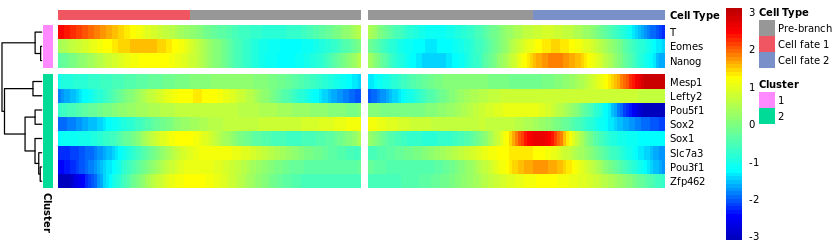

In [428]:
plotPseudoGLNumClust(2)

#### Clusters = 3

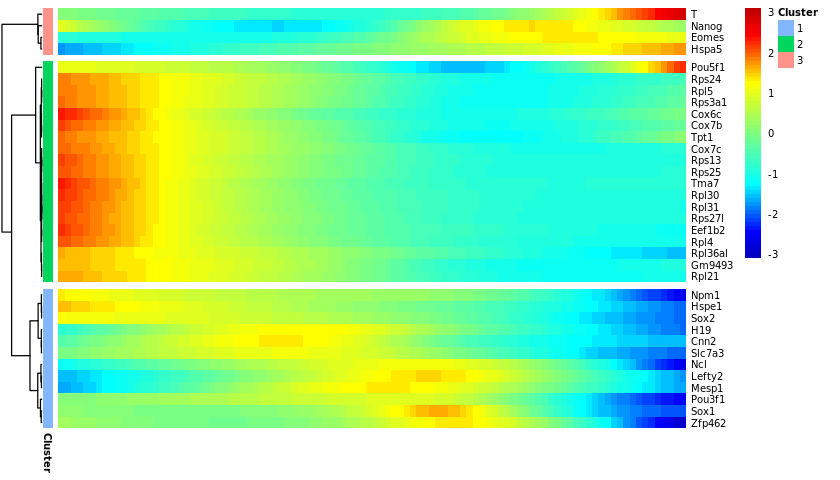

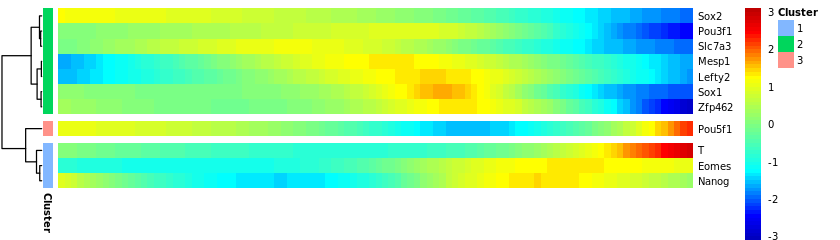

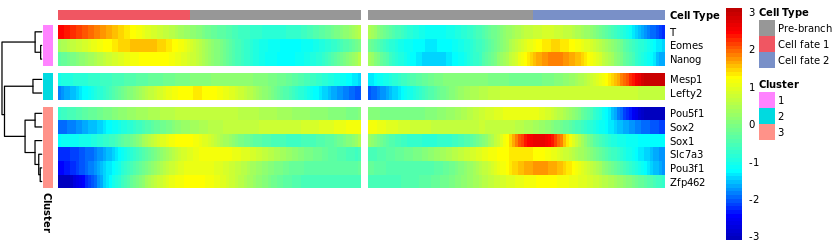

In [429]:
plotPseudoGLNumClust(3)

#### Clusters = 4

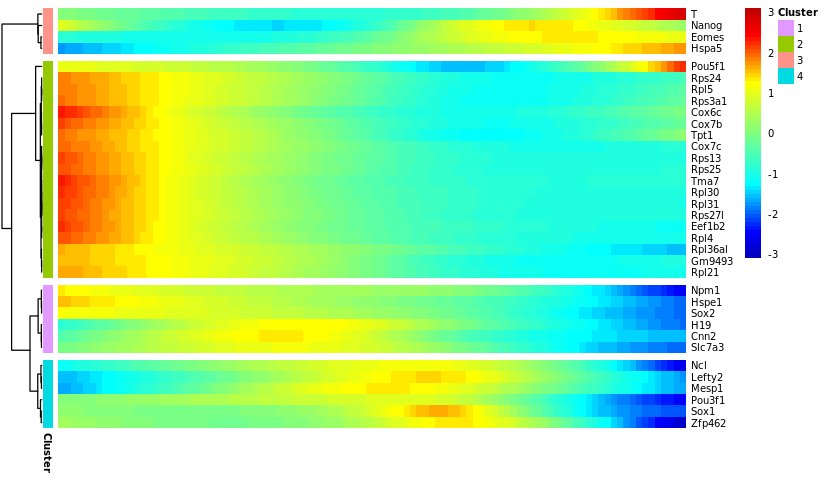

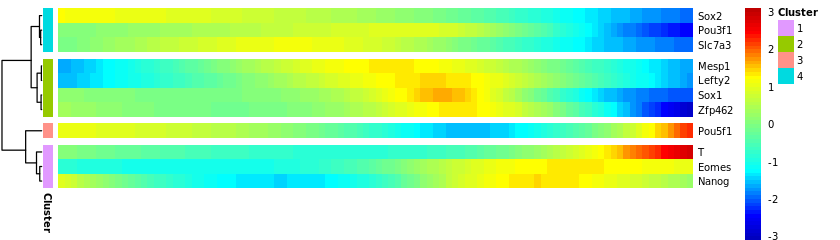

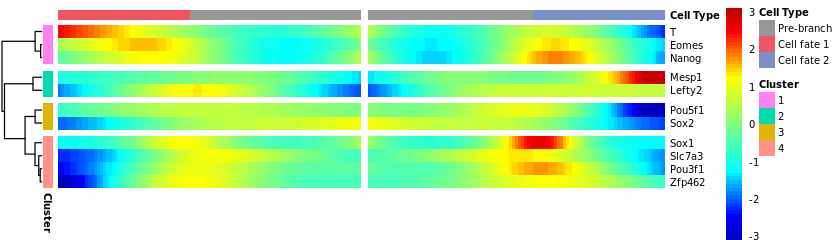

In [430]:
plotPseudoGLNumClust(4)

#### Clusters = 5

Pou5f1 finally splits off into its own cluster, but T and Eomes are still in the same cluster when considered in a wider scope of genes -- although restricting the analysis to just our genes of interest does split the two (however they appear to have the same cell fate).

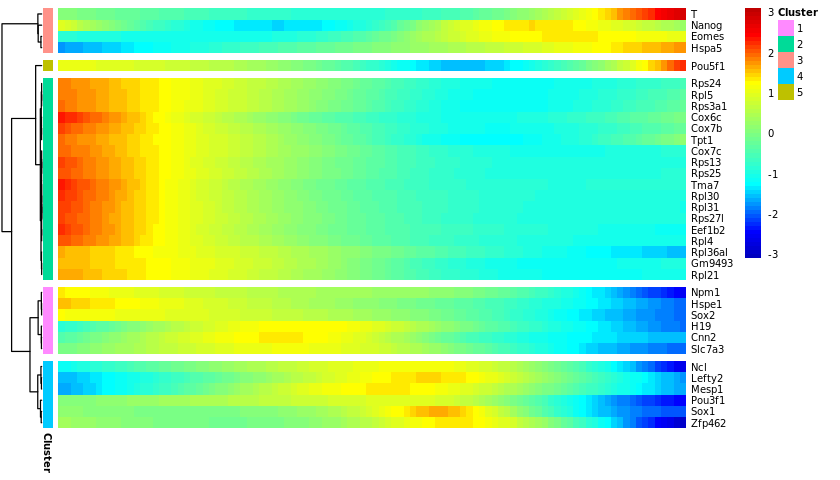

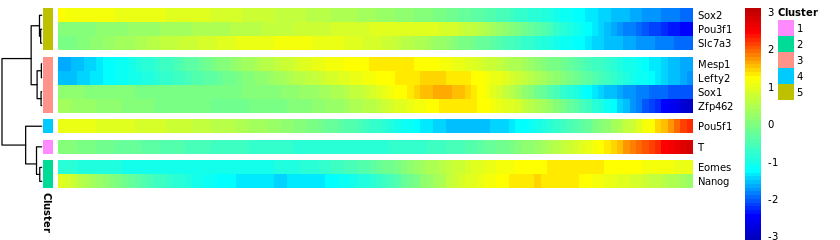

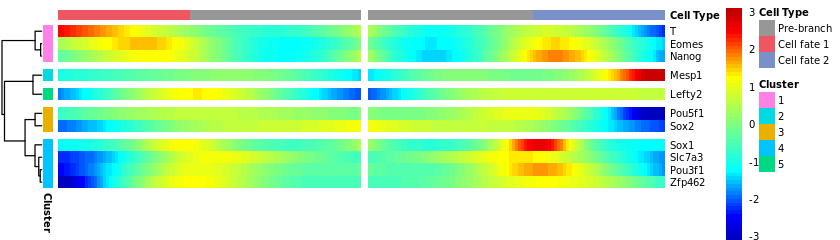

In [431]:
plotPseudoGLNumClust(5)

#### Clusters = 6

Sox1 splits off from Lefty2...

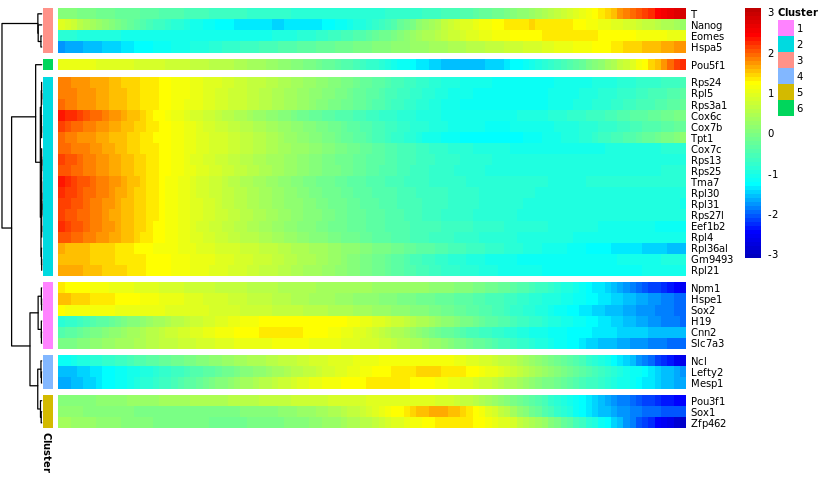

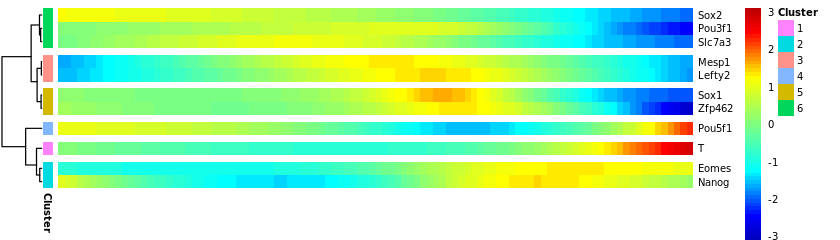

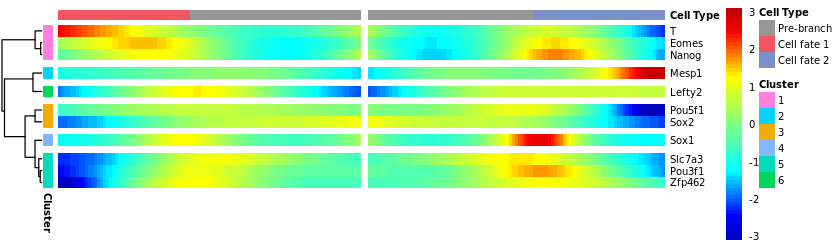

In [432]:
plotPseudoGLNumClust(6)

#### Clusters = 7

Really nice clustering here, T splits off from Eomes.

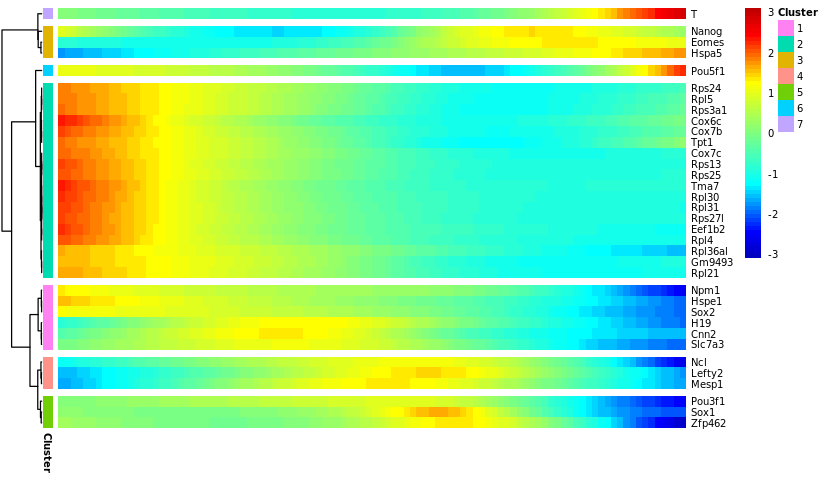

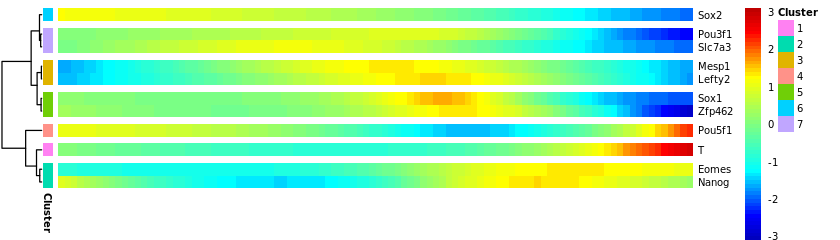

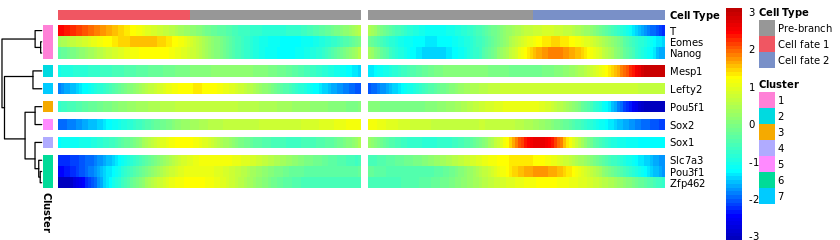

In [433]:
plotPseudoGLNumClust(7)

#### Clusters = 8

Npm1 splits off from H19 cluster

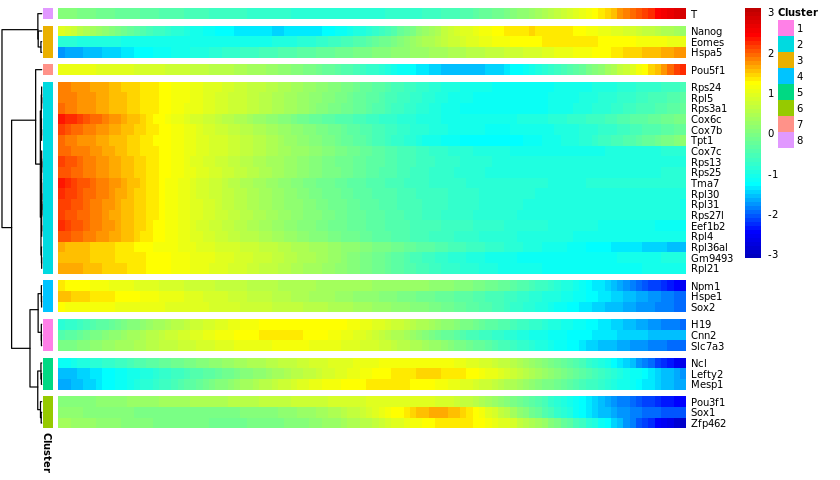

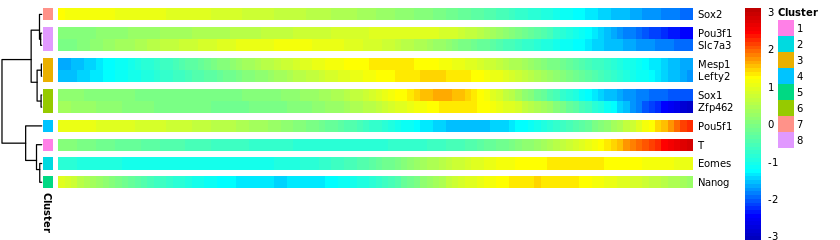

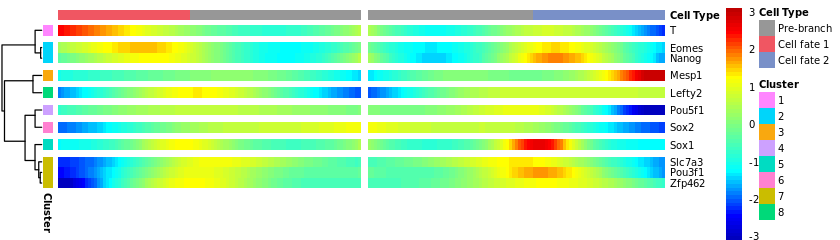

In [434]:
plotPseudoGLNumClust(8)

#### Clusters = 9

Eomes splits off from Nanog (Mesoderm splits off from ES)

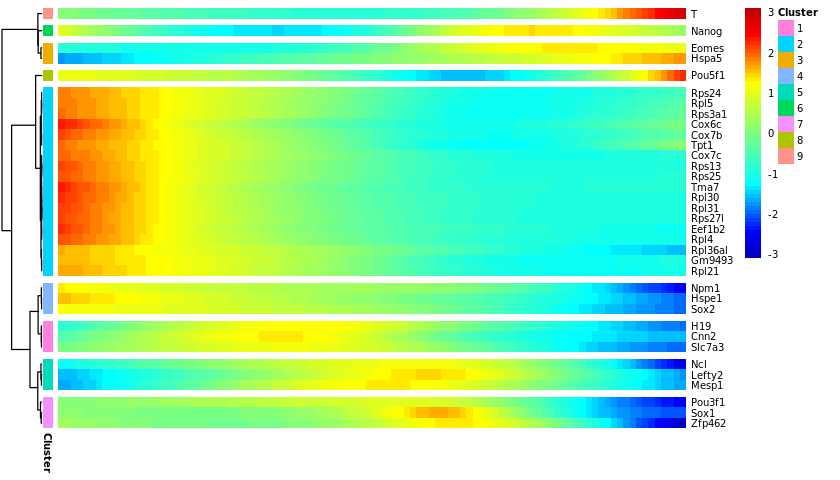

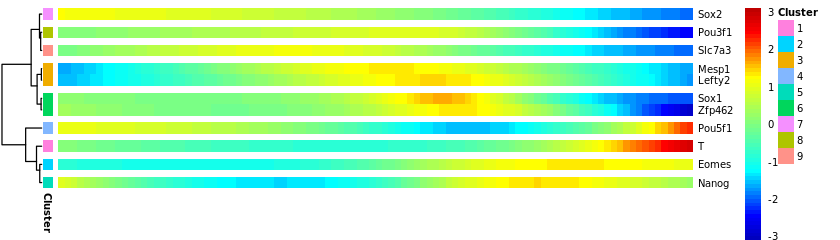

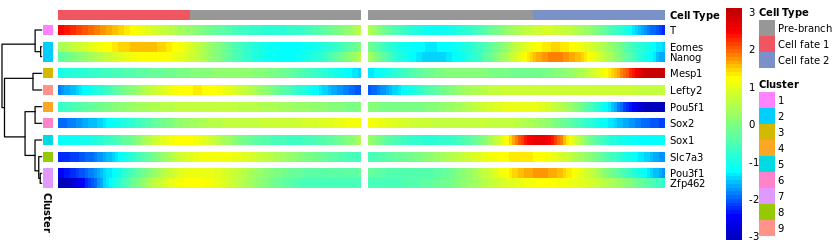

In [435]:
plotPseudoGLNumClust(9)

### Branching pseudotime 

Looking at how the different genes branch in pseudotime

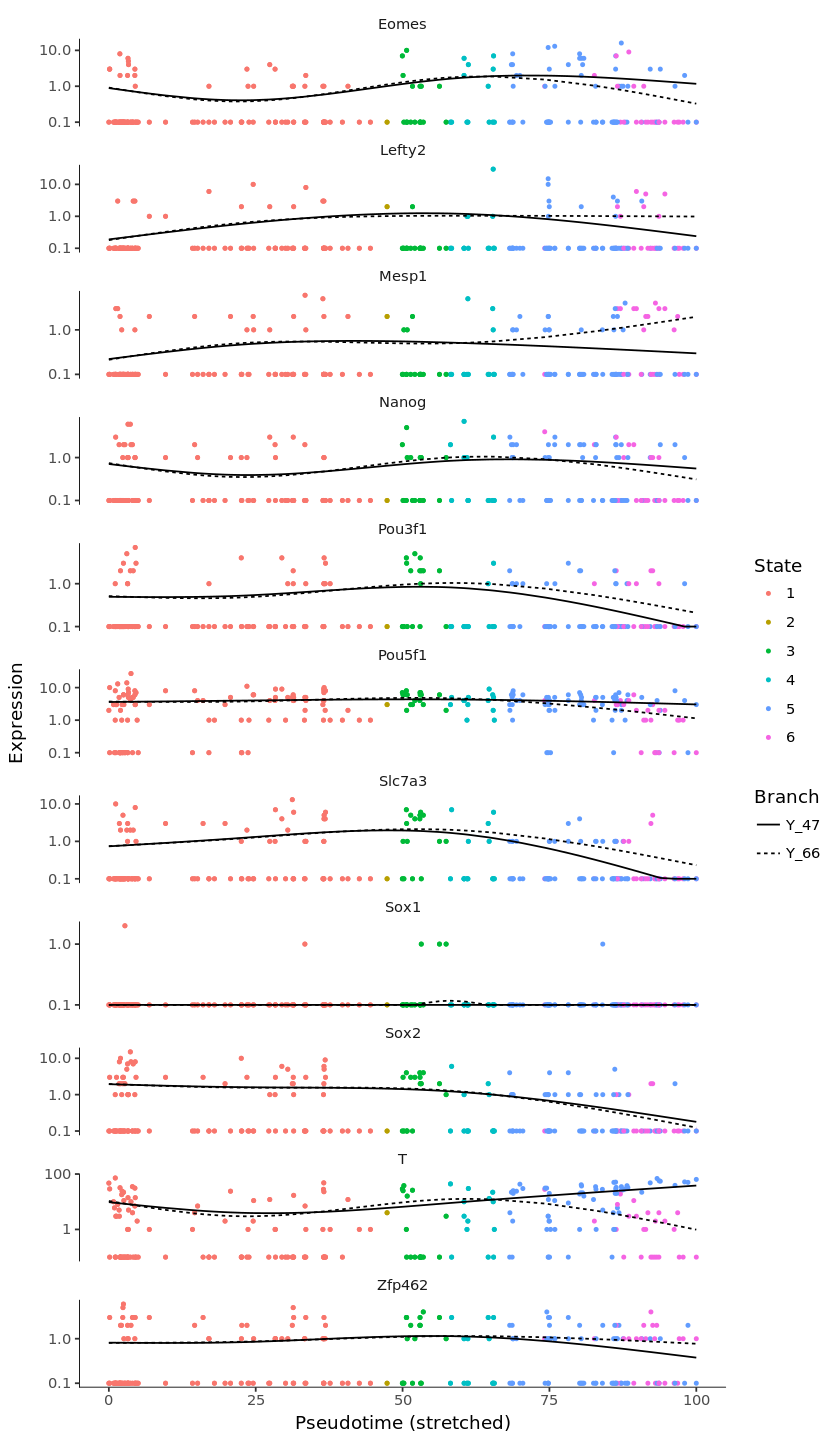

In [330]:
options(repr.plot.height = 12)
plot_genes_branched_pseudotime(HSMM[gene_list,])

In [331]:
disp_table <- dispersionTable(HSMM)
ordering_genes <- subset(disp_table, mean_expression >= 0.1)
HSMM <- setOrderingFilter(HSMM, ordering_genes)

In [332]:
head(ordering_genes)

gene_id       mean_expression dispersion_fit dispersion_empirical
1 0610007P14Rik 0.5528186        3.742503       0.000000           
2 0610009B22Rik 0.5303876        3.900780       3.400387           
5 0610009O20Rik 0.1820462       11.364835      20.159160           
6 0610010F05Rik 0.1594320       12.976847       0.000000           
7 0610010K14Rik 0.8774553        2.357870       0.000000           
8 0610011F06Rik 0.4015765        5.152008       8.723382